In [2]:
# Load modules and data
# from linares_plot import *
from scipy.stats import ks_2samp
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
import sklearn
import sinaplot
import json
import warnings
from scipy import special
from statsmodels.formula.api import ols
import matplotlib.gridspec as gridspec
import statsmodels.formula.api as smf

#Import all needed libraries
from matplotlib.lines import Line2D
import os
import pandas as pd
import numpy as np
from datahandler import Utils
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as mpatches
from statannot import add_stat_annotation
import itertools
from scipy import stats as st
from datahandler import Utils
from ast import literal_eval
from glob import glob
from open_ephys.analysis import Session
import pyopenephys

# plt.rcParams['figure.dpi'] = 200
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM

os.getcwd() 
os.chdir('C:/Users/Tiffany/Google Drive/WORKING_MEMORY/EXPERIMENTS/ANALYSIS CODES')
import tools_code as tools

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
# warnings.simplefilter(action='ignore', category=PerformanceWarning)
warnings. filterwarnings('ignore', category=UserWarning)
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
def unnesting(df, explode):
    """
    Unnest columns that contain list creating a new row for each element in the list.
    The number of elements must be the same for all the columns, row by row.
    """
    length = df[explode[0]].str.len()
    idx = df.index.repeat(length)
    df1 = pd.concat([pd.DataFrame({x: np.concatenate(df[x].values)}) for x in explode], axis=1)
    df1.index = idx
    finaldf = df1.join(df.drop(explode, 1), how='left')
    finaldf.reset_index(drop=True, inplace=True)

    length2 = [list(range(l)) for l in length]
    length2 = [item + 1 for sublist in length2 for item in sublist]
    name = explode[0] + '_index'
    finaldf[name] = length2

    for column in finaldf.columns:
        try:
            if set(finaldf[column]) <= {'True', 'False', 'nan'}:
                replacing = {'True': True, 'False': False, 'nan': np.nan}
                finaldf[column] = finaldf[column].map(replacing)
        except:
            pass
    return finaldf

def fix_delays_model(row):
    delays=[0.0,500,1000,2000,3000,4000,5000,7000,9000,10000]
    return delays[row['idelays']-1]/1000

def fix_delays(row):
#     delays=[0.0,500,1000,2000,3000,4000,5000,7000,9000,10000]
    delays=[100,1000,3000,10000]
    return delays[row['idelays']-1]/1000

def streak(row):
    value = 0
    '''
    Skipping the first trial, look for whether there was a sequences of same side trials or opposite side trials
    '''
    if row['trial'] != 1:
        if row['stim'] == row['past_choices'][0]:
            value = 1
            if row['past_choices'][0] == row['past_choices'][1]:
                value = 2
                if row['past_choices'][1] == row['past_choices'][2]:
                    value = 3
        else: 
            value = -1
            if row['past_choices'][0] == row['past_choices'][1]:
                value = -2
                if row['past_choices'][1] == row['past_choices'][2]:
                    value = -3 
                else:
                    value = -2
                    return value
            else:
                value = -1
                return value
    return value

# Create a repeating vector
def repeat_choice(row):
    val = 0
    if row['choices'] == row['past_choices'][0]:
        val = 1
    elif row['past_choices'][0] == 0:
        val = np.nan
    else:
        val = 0
    return val

def repeat_choice_side(row):
    '''
    Parameters
    ----------
    row : look row by row whether there was a repetition of LEFT response (1) or RIGHT response (2)

    Returns
    -------
    TYPE
        DESCRIPTION.

    '''
    # Compare the current response with the previous one. If that matches, return a 1 meaning it repeated. 
    if row['trial'] != 0:
        # Compare the current response with the previous one. .  
        if row['choices'] == row['past_choices'][0]:
            # if it matched and the answer was 1, it means that it repeated a right response
            if row['choices'] == 1:
                return 2
            # if it matched and the answer was 0, it means that it repeated a left response
            else:
                return 1
        elif row['past_choices'][0] == 0:
            return 0
        else:
            return 0
    else:
        return np.nan
        
def compute_window(data, runningwindow,option):
    """
    Computes a rolling average with a length of runningwindow samples.
    """
    performance = []
    end=False
    for i in range(len(data)):
        if data['trial'].iloc[i] <= runningwindow:
            # Store the first index of that session
            if end == False:
                start=i
                end=True
            performance.append(round(np.mean(data[option].iloc[start:i + 1]), 2))
        else:
            end=False
            performance.append(round(np.mean(data[option].iloc[i - runningwindow:i]), 2))
    return performance

def compute_window_centered(data, runningwindow,option):
    """
    Computes a rolling average with a length of runningwindow samples.
    """
    performance = []
    start_on=False
    for i in range(len(data)):
        if data['trial'].iloc[i] <= int(runningwindow/2):
            # Store the first index of that session for the first initial trials
            if start_on == False:
                start=i
                start_on=True
            performance.append(round(np.mean(data[option].iloc[start:i + int(runningwindow/2)]), 2))
        elif i < (len(data)-runningwindow):
            if data['trial'].iloc[i] > data['trial'].iloc[i+runningwindow]:
                # Store the last values for the end of the session
                if end == True:
                    end_value = i+runningwindow-1
                    end = False
                performance.append(round(np.mean(data[option].iloc[i:end_value]), 2))
                
            else: # Rest of the session
                start_on=False
                end = True
                performance.append(round(np.mean(data[option].iloc[i - int(runningwindow/2):i+int(runningwindow/2)]), 2))
            
        else:
            performance.append(round(np.mean(data[option].iloc[i:len(data)]), 2))
    return performance

In [4]:
obtain_path = 'C:/Users/Tiffany/Google Drive/WORKING_MEMORY/PAPER/Figures/'
save_path = 'C:/Users/Tiffany/Google Drive/WORKING_MEMORY/PAPER/Panel figures/Fig. 3. Pharma/'
sns.set_context('talk')

___________
### Session separated according to treatment and then fitted independently

In [11]:
def create_data(animal,extra):
    os.getcwd() 
    os.chdir('C:/Users/Tiffany/Desktop/HMM_mice/real/')

    with open(animal+'_behavior_'+extra+'.json', 'r') as j:
        json_data = json.load(j)

    df_real = pd.DataFrame.from_dict(json_data, orient='columns', dtype=None, columns=None)

    with open(animal+'_synthetic_behavior_'+extra+'.json', 'r') as j:
        json_data = json.load(j)

    df = pd.DataFrame.from_dict(json_data, orient='columns', dtype=None, columns=None)

    with open(animal+'_fit_'+extra+'.json', 'r') as j:
        json_data = json.load(j)

    fit = pd.DataFrame.from_dict(json_data, orient='columns', dtype=None, columns=None)
    
    # ----------- Create new PR and PL in the dataframe
    c2 = fit.loc[fit.args=='c2']['ParamFit'].iloc[0]
    muk = fit.loc[fit.args=='mu_k']['ParamFit'].iloc[0]
    mub = fit.loc[fit.args=='mu_b']['ParamFit'].iloc[0]
    x0 = fit.loc[fit.args=='x0']['ParamFit'].iloc[0]

    XR =  np.sqrt(c2/4) + (muk + mub)/(2 * c2)
    XL =  -np.sqrt(c2/4) + (muk + mub)/(2 * c2)
    upper = special.erf(np.array(np.sqrt(c2) * (x0 + (muk + mub)/(c2)))) - special.erf(np.array(np.sqrt(c2) * (XL + (muk + mub)/(c2))))
    lower = special.erf(np.array(np.sqrt(c2) * (XR + (muk + mub)/(c2)))) - special.erf(np.array(np.sqrt(c2) * (XL + (muk + mub)/(c2))))
    P_R = upper/lower

    XR =  np.sqrt(c2/4) + (-muk + mub)/(2 * c2)
    XL =  -np.sqrt(c2/4) + (-muk + mub)/(2 * c2)
    upper = special.erf(np.array(np.sqrt(c2) * (x0 + (-muk + mub)/(c2)))) - special.erf(np.array(np.sqrt(c2) * (XR + (-muk + mub)/(c2))))
    lower = special.erf(np.array(np.sqrt(c2) * (XL + (-muk + mub)/(c2)))) - special.erf(np.array(np.sqrt(c2) * (XR + (-muk + mub)/(c2))))
    P_L = upper/lower

    new_row = {'args':'P_R', 'LL': fit['LL'][0], 'ParamFit':P_R}
    fit = fit.append(new_row, ignore_index=True)

    new_row = {'args':'P_L', 'LL': fit['LL'][0], 'ParamFit':P_L}
    fit = fit.append(new_row, ignore_index=True)
    fit.ParamFit = np.around(fit.ParamFit,3)

    # -----------------------------------------------------
        
    
    # Reset index and create column for session
    df.reset_index(inplace=True)
    df.rename(columns = {'index':'session'}, inplace = True)

    df_real.reset_index(inplace=True)
    df_real.rename(columns = {'index':'session'}, inplace = True)

    # Unnest several parameters so it is one per row
    new_df = Utils.unnesting(df, ['choices', 'stim','idelays'])
    try:
        new_df_real = Utils.unnesting(df_real, ['choices','Delay_OFF','C_s','L_s','Response_ON','stim','idelays','day'])
    except:
        print('No licks or time window')
        new_df_real = Utils.unnesting(df_real, ['choices','stim','idelays','day'])

    # Prepare the past choices
    addition=[]
    for k in range(len(df.past_choices)):
        for i in range(len(df['past_choices'][k])):
            addition.append(df['past_choices'][k][i])
    new_df['past_choices'] = addition

    addition=[]
    for k in range(len(df_real.past_choices)):
        for i in range(len(df_real['past_choices'][k])):
            addition.append(df_real['past_choices'][k][i])
    new_df_real['past_choices'] = addition

    # Prepare past rewards
    addition=[]
    for k in range(len(df.past_rewards)):
        for i in range(len(df['past_rewards'][k])):
            addition.append(df['past_rewards'][k][i])
    new_df['past_rewards'] = addition

    addition=[]
    for k in range(len(df_real.past_rewards)):
        for i in range(len(df_real['past_rewards'][k])):
            addition.append(df_real['past_rewards'][k][i])
    new_df_real['past_rewards'] = addition

    # Prepare states
    addition=[]
    for k in range(len(df_real.Pstate)):
        for i in range(len(df_real['Pstate'][k])):
            addition.append(df_real['Pstate'][k][i])
    new_df_real['state'] = addition

    addition=[]
    for k in range(len(df.state)):
        for i in range(len(df['state'][k])):
            addition.append(df['state'][k][i])
    new_df['state'] = addition

    # ---------------
    def after_correct(row):
        return row['past_rewards'][0]

    new_df['after_correct'] = new_df.apply(after_correct, axis=1)
    new_df_real['after_correct'] = new_df_real.apply(after_correct, axis=1)
    
    # Next delays
    new_df['delays'] = new_df.apply(fix_delays_model, axis=1)
    new_df_real['delays'] = new_df_real.apply(fix_delays, axis=1)

    # -------
    new_df.rename(columns = {'choices_index':'trial'}, inplace = True)
    new_df['session'] = new_df['session'].astype(int)

    new_df_real.rename(columns = {'choices_index':'trial'}, inplace = True)
    new_df_real['session'] = new_df_real['session'].astype(int)

    # Revalue variables stim, choices and create hit vector. -1 means Left and 1 means right. 1 for correct in hit and 0 for incorrect
    new_df['stim']= np.where(new_df['stim'] == 1, -1, 1)
    new_df['choices']= np.where(new_df['choices'] == 1, -1, 1)
    new_df['hit'] = np.where(new_df['stim'] == new_df['choices'], 1, 0)

    # Revalue variables stim, choices and create hit vector. -1 means Left and 1 means right. 1 for correct in hit and 0 for incorrect
    new_df_real['stim']= np.where(new_df_real['stim'] == 1, -1, 1)
    new_df_real['choices']= np.where(new_df_real['choices'] == 1, -1, 1)
    new_df_real['hit'] = np.where(new_df_real['stim'] == new_df_real['choices'], 1, 0)

    new_df_real['repeat'] = new_df_real.apply(repeat_choice,axis=1)
    new_df['repeat'] = new_df.apply(repeat_choice,axis=1)

    new_df_real['repeat_choice_side'] = new_df_real.apply(repeat_choice_side,axis=1)
    new_df['repeat_choice_side'] = new_df.apply(repeat_choice_side,axis=1)

    temp = pd.DataFrame(new_df_real['state'].tolist())
    new_df_real['WM'] = temp[0]
    new_df_real['RL'] = temp[1]

    new_df['state'] = np.where(new_df['state'] == 1, 1,0)
    
    # Correct the sequences of repetitions and alternations
    new_df['streak'] = new_df.apply(streak,axis=1)
    new_df_real['streak'] = new_df_real.apply(streak,axis=1)

    total_list = []
    for session in new_df_real.session.unique():
        maxim=new_df_real.loc[new_df_real.session==session]['trial'].max()
        total_list.extend(np.repeat(maxim, len(new_df_real.loc[new_df_real.session==session]['trial'].unique())))
    new_df_real['total_trial'] = total_list
    
    total_list = []
    for session in new_df.session.unique():
        maxim=new_df.loc[new_df.session==session]['trial'].max()
        total_list.extend(np.repeat(maxim, len(new_df.loc[new_df.session==session]['trial'].unique())))
    new_df['total_trial'] = total_list
    
    # ------
#     print('Total trials for WM: ', new_df_real[new_df_real["WM"]>0.75]["stim"].count()/new_df_real["stim"].count())
#     print('Total trials for RL: ', new_df_real[new_df_real["RL"]>0.25]["stim"].count()/new_df_real["stim"].count())

#     print('Total trials for WM: ', new_df[new_df["state"]==1]["stim"].count()/new_df["stim"].count())
#     print('Total trials for RL: ', new_df[new_df["state"]==0]["stim"].count()/new_df["stim"].count())
    # ---------

    new_df.drop(columns = {"idelays"}, inplace=True)
    new_df_real.drop(columns = {"state", "idelays","Pstate"}, inplace=True)
    
    return new_df, new_df_real, fit

In [9]:
def compare_synthetic(new_df,new_df_real,animal='None', WM=0.8, RL=0.2):
    Right = 'darkorange'
    Left = 'teal'
    
    os.getcwd() 
    os.chdir('C:/Users/Tiffany/Google Drive/WORKING_MEMORY/MODEL/HMM_wm_mice-main/figures/')
    fig = plt.figure(figsize=(16,12))

# --------------------------------------
    ax = plt.subplot(341)
    df_results =pd.DataFrame()
    df_results['accuracy'] = new_df_real.groupby(['delays','session','stim'])['hit'].mean()
    df_results.reset_index(inplace=True)      

    sns.lineplot(x='delays',y='accuracy',data=df_results, marker='o',color='black', linestyle = '', err_style="bars")
    sns.lineplot(x='delays',y='accuracy',hue='stim',data=df_results, marker='o', palette=[Left,Right], linestyle = '', err_style="bars",legend=False)


    df_results =pd.DataFrame()
    df_results['accuracy'] = new_df.groupby(['delays'])['hit'].mean()
    df_results.reset_index(inplace=True)   
    sns.lineplot(x='delays',y='accuracy',data=df_results,color='black')
    
    df_results =pd.DataFrame()
    df_results['accuracy'] = new_df.groupby(['delays','stim'])['hit'].mean()
    df_results.reset_index(inplace=True)   
    sns.lineplot(x='delays',y='accuracy',hue='stim',data=df_results, palette=[Left,Right], legend=False)

    plt.ylim(0.4,1)
    plt.hlines(xmin=0,xmax=10, y=0.5, linestyles = ':')
    plt.xlabel("Delays (s)")
    plt.ylabel(" Accuracy")
    
    def add_value_label(x_list,y_list):
        for i in range(1, len(x_list)+1):
            plt.text(i,y_list[i-1],y_list[i-1], ha="center")

    timeWM=np.around(new_df[new_df["state"]==1]["stim"].count()/new_df["stim"].count()*100,1)
    timeHB=np.around(new_df[new_df["state"]==0]["stim"].count()/new_df["stim"].count()*100,1)
    left, bottom, width, height = [0.08, 0.75, 0.05, 0.10]
    ax = fig.add_axes([left, bottom, width, height])
    bars = ax.bar([1,2], [timeWM,timeHB], color=['darkgreen','indigo'],alpha=0.8)
    add_value_label([1,2], [timeWM,timeHB])
    plt.axis('off')
    sns.despine()

# ------------------------------------------- 
    plt.subplot(342)
    grouping=['delays','session']
    df_results =pd.DataFrame()
    df_results['repeat'] = (new_df_real.loc[(new_df_real['repeat_choice_side']==1)].groupby(grouping)['trial'].count()/
                            new_df_real.loc[(new_df_real.choices == -1)].groupby(grouping)['trial'].count()) 
    df_results.reset_index(inplace=True) 
    sns.lineplot(x='delays',y='repeat',data=df_results, marker='o',color=Left,err_style="bars", linestyle = '', label = 'L data')

    df_results =pd.DataFrame()
    df_results['repeat'] = (new_df_real.loc[(new_df_real['repeat_choice_side']==2)].groupby(grouping)['trial'].count()/
                            new_df_real.loc[(new_df_real.choices == 1)].groupby(grouping)['trial'].count()) 
    df_results.reset_index(inplace=True) 
    sns.lineplot(x='delays',y='repeat',data=df_results, marker='o',color=Right,err_style="bars", linestyle = '', label = 'R data')

    df_results =pd.DataFrame()
    df_results['repeat'] = (new_df.loc[(new_df['repeat_choice_side']==1)].groupby(grouping)['trial'].count()/
                            new_df.loc[(new_df.choices == -1)].groupby(grouping)['trial'].count()) 
    df_results.reset_index(inplace=True)        
    sns.lineplot(x='delays',y='repeat',data=df_results,color=Left, label = 'L model')
                            
    df_results =pd.DataFrame()
    df_results['repeat'] = (new_df.loc[(new_df['repeat_choice_side']==2)].groupby(grouping)['trial'].count()/
                            new_df.loc[(new_df.choices == 1)].groupby(grouping)['trial'].count()) 
    df_results.reset_index(inplace=True)  
                            
    sns.lineplot(x='delays',y='repeat',data=df_results,color=Right, label = 'R model')
                            
    plt.ylim(0.4,1)
    plt.hlines(xmin=0,xmax=10, y=0.5, linestyles = ':')
    plt.xlabel("Delays (s)")
    plt.ylabel("Repeating bias")
    
# --------------------------------------
    plt.subplot(343)
    grouping=['delays','session','stim']
    df_results =pd.DataFrame()
    df_results['Pright'] = new_df_real.loc[new_df_real.choices==1].groupby(grouping)['trial'].count()/new_df_real.groupby(grouping)['trial'].count()                      
    df_results.reset_index(inplace=True)
    sns.lineplot(x='delays',y='Pright',hue='stim',data=df_results, marker='o',err_style="bars",linestyle='',legend=None,  palette=[Left,Right])
    sns.lineplot(x='delays',y='Pright',data=df_results, marker='o',err_style="bars", linestyle='',legend=None, color='black')

    df_results =pd.DataFrame()
    df_results['Pright'] = new_df.loc[new_df.choices==1].groupby(grouping)['trial'].count()/new_df.groupby(grouping)['trial'].count()                      
    df_results.reset_index(inplace=True)
    sns.lineplot(x='delays',y='Pright',hue='stim',data=df_results, legend=None, palette=[Left,Right])
    sns.lineplot(x='delays',y='Pright',data=df_results, legend=None, color='black')

    plt.xlabel("Delays (s)")
    plt.ylabel("P(right)")
    plt.hlines(xmin=0,xmax=10, y=0.5, linestyles = ':')
    plt.suptitle(animal)
    sns.despine()
    
    plt.subplot(344)
    position = 0
    plt.axis('off')
    for index in range(len(fit.ParamFit)):
        position+=0.1
        plt.text(x=0,y=position,s=str(fit.args[index])+': '+str(fit.ParamFit[index]))
    plt.text(x=0,y=position+0.1,s='Number of trials:' + str(len(new_df_real)))
    
# ----------------------------------
    plt.subplot(345)
    df_results =pd.DataFrame()
    df_results['accuracy'] = new_df_real.groupby(['delays','session','after_correct'])['hit'].mean()
    df_results.reset_index(inplace=True)
    df_results.dropna(inplace=True)
    sns.lineplot(x='delays',y='accuracy',hue='after_correct',data=df_results.loc[df_results.after_correct!=-1], marker='o', palette=['crimson','darkgreen'], linestyle = '', err_style="bars", legend=False)

    df_results =pd.DataFrame()
    df_results['accuracy'] = new_df.groupby(['delays','session','after_correct'])['hit'].mean()
    df_results.reset_index(inplace=True)  
    df_results.dropna(inplace=True)
    sns.lineplot(x='delays',y='accuracy',hue='after_correct',data=df_results.loc[df_results.after_correct!=-1], marker='', palette=['crimson','darkgreen'],  legend=False)
    plt.hlines(xmin=0,xmax=10, y=0.5, linestyles = ':')
    plt.xlabel("Delays (s)")
    plt.ylim(0.4,1)
    plt.ylabel(" Accuracy")
    sns.despine()
    
# ----------------------------------------
    plt.subplot(346)
    grouping=['delays','session','after_correct']
    df_results =pd.DataFrame()
    df_results['repeat'] = (0.5*(new_df_real.loc[(new_df_real['repeat_choice_side']==2)].groupby(grouping)['trial'].count()/
                            new_df_real.loc[(new_df_real.choices == 1)].groupby(grouping)['trial'].count()) +  
                            0.5*(new_df_real.loc[(new_df_real['repeat_choice_side']==1)].groupby(grouping)['trial'].count()/
                            new_df_real.loc[(new_df_real.choices == -1)].groupby(grouping)['trial'].count()))
    df_results['repeat'] = new_df_real.groupby(grouping)['repeat'].mean()
    df_results.reset_index(inplace=True)  
    df_results.dropna(inplace=True)
    sns.lineplot(x='delays',y='repeat',data=df_results, marker='o',hue='after_correct', palette=['crimson','darkgreen'], legend=False,err_style="bars", linestyle = '')

    df_results =pd.DataFrame()
    df_results['repeat'] = (0.5*(new_df.loc[(new_df['repeat_choice_side']==2)].groupby(grouping)['trial'].count()/
                            new_df.loc[(new_df.choices == 1)].groupby(grouping)['trial'].count()) +  
                            0.5*(new_df.loc[(new_df['repeat_choice_side']==1)].groupby(grouping)['trial'].count()/
                            new_df.loc[(new_df.choices == -1)].groupby(grouping)['trial'].count()))
    df_results.reset_index(inplace=True)  
    df_results.dropna(inplace=True)

    sns.lineplot(x='delays',y='repeat',data=df_results,hue='after_correct', palette=['crimson','darkgreen'],legend=False)
    plt.hlines(xmin=0,xmax=10, y=0.5, linestyles = ':')
    plt.ylim(0.4,1)
    legend_elements = [Line2D([0], [0], color='crimson', label='Incorrect'),
                       Line2D([0], [0], color='darkgreen', label='Correct')]

    plt.legend(handles=legend_elements, ncol=1).get_frame().set_linewidth(0.0)
    plt.xlabel("Delays (s)")
    plt.ylabel("Repeating bias")
    sns.despine()      
    
# -------------------------------------------------- Plots for streaks of repetitions and alternations 
    # Computing accuracy
    cmap = sns.diverging_palette(15,250, s=100, l=60, n=len(new_df.loc[new_df.streak != 0].streak.unique()), center="dark")
    plt.subplot(347)
    df_results = pd.DataFrame()
    df_results['accuracy'] = new_df.loc[new_df.streak != 0].groupby(['delays','session','streak'])['hit'].mean()
    df_results.reset_index(inplace=True)
    sns.lineplot(x='delays',y='accuracy',hue='streak', data=df_results, ci=68, legend=False,palette=cmap)

    df_results = pd.DataFrame()
    df_results['accuracy'] = new_df_real.loc[new_df_real.streak != 0].groupby(['delays','session','streak'])['hit'].mean()
    df_results.reset_index(inplace=True)
    sns.lineplot(x='delays',y='accuracy',hue='streak', data=df_results, ci=68, linestyle='', marker='o', err_style="bars",legend=False, palette=cmap)
    plt.hlines(xmin=0,xmax=10, y=0.5, linestyles = ':')
    plt.ylim(0.4,1)
    plt.xlabel("Delays (s)")
    plt.ylabel(" Accuracy")
    sns.despine()

# ------------- Legend for repetition and alternation plot
    plt.subplot(348)
    plt.axis('off')
    legend_elements = [Line2D([0], [0], color=cmap[-1], label='XXX'),
                       Line2D([0], [0], color=cmap[-2], label='XX'),
                       Line2D([0], [0],  color = cmap[-3], label='X'),
                       Line2D([0], [0],  color=cmap[2],label='Y'),
                       Line2D([0], [0], color=cmap[1], label='YY'),
                       Line2D([0], [0], color=cmap[0], label='YYY')]

    plt.legend(handles=legend_elements, ncol=1, bbox_to_anchor=(0.2, 1),borderaxespad=0).get_frame().set_linewidth(0.0)

# ----------------Separation for modules_____________________
# ---------- Accuracy
    plt.subplot(349)
    
    sns.lineplot(x='delays',y='hit',data=new_df_real, err_style='bars', marker='o',color='black', linestyle='')
    sns.lineplot(x='delays',y='hit',data=new_df_real.loc[new_df_real['RL']>RL], err_style='bars', marker='o',color='indigo', linestyle='')
    sns.lineplot(x='delays',y='hit',data=new_df_real.loc[new_df_real['WM']>WM], err_style='bars', marker='o',color='darkgreen', linestyle='')
#     sns.lineplot(x='delays',y='hit',data=new_df_real.loc[new_df_real['RL']>0.2], err_style='bars', marker='o',color='indigo', linestyle=':')
#     sns.lineplot(x='delays',y='hit',data=new_df_real.loc[new_df_real['WM']>0.8], err_style='bars', marker='o',color='darkgreen', linestyle=':')
        
    sns.lineplot(x='delays',y='hit',data=new_df,  err_style=None,marker='',color='black')
    sns.lineplot(x='delays',y='hit',data=new_df.loc[new_df['state']==0], marker='',color='indigo')
    sns.lineplot(x='delays',y='hit',data=new_df.loc[new_df['state']==1], marker='',color='darkgreen')
    plt.hlines(xmin=0,xmax=10, y=0.5, linestyles = ':')
    plt.xlabel("Delays (s)")
    plt.ylabel(" Accuracy")
    plt.ylim(0.1,1)
    
# ---------- RB
    plt.subplot(3,4,10)
    sns.lineplot(x='delays',y='repeat',data=new_df_real, err_style='bars', marker='o',color='black', linestyle='')
    sns.lineplot(x='delays',y='repeat',data=new_df_real.loc[new_df_real['RL']>RL], err_style='bars', marker='o',color='indigo', linestyle='')
    sns.lineplot(x='delays',y='repeat',data=new_df_real.loc[new_df_real['WM']>WM], err_style='bars', marker='o',color='darkgreen', linestyle='')
       
    sns.lineplot(x='delays',y='repeat',data=new_df,  marker='',color='black')
    sns.lineplot(x='delays',y='repeat',data=new_df.loc[new_df['state']==0], marker='',color='indigo')
    sns.lineplot(x='delays',y='repeat',data=new_df.loc[new_df['state']==1], marker='',color='darkgreen')
    
    plt.hlines(xmin=0,xmax=10, y=0.5, linestyles = ':')
    plt.ylim(0.4,1.1)
    plt.xlabel("Delays (s)")
    plt.ylabel("Repeating bias")
    sns.despine()

    plt.subplot(3,4,11)
    plt.axis('off')
    legend_elements = [Line2D([0], [0], color='darkgreen', label='WM'),
                       Line2D([0], [0], color='black', label='All'),
                       Line2D([0], [0],  color = 'indigo', label='RL')]

    plt.legend(handles=legend_elements, ncol=1, bbox_to_anchor=(0.2, 1),borderaxespad=0.1).get_frame().set_linewidth(0.0)

    plt.tight_layout()
    plt.savefig(animal+'_lateral bias acc, rb, pright, aftercorrect, modules_'+extra+'_fixed.svg')
    plt.show()

In [12]:
full_fit = pd.DataFrame(dtype = 'float')
extra='all'
all_data = pd.DataFrame()
all_data_model=pd.DataFrame()
list_name=["C28_NR2B_drug", "C34_NR2B_drug", "C37_NR2B_drug", "C38_NR2B_drug", "N19_NR2B_drug", "N27_NR2B_drug", "N24_NR2B_drug", "N28_NR2B_drug", "N25_NR2B_drug", "E10_NR2B_drug", "E11_NR2B_drug", "E13_NR2B_drug"]

for animal in list_name:
    print(animal)
    new_df, new_df_real, fit = create_data(animal,extra)
    # compare_synthetic(new_df, new_df_real,animal)

    res = fit[['args','ParamFit']].T
    res.columns = res.iloc[0]
    res['subject'] = animal[:3]   
    res['acc'] = np.mean(new_df_real.groupby('session').hit.mean())
    res['drug'] = 'drug'
    res.drop(index='args',inplace=True)
    
    res['WM'] = new_df_real[(new_df_real["WM"]>0.65)]["stim"].count()/new_df_real["stim"].count()
    res['RL'] =new_df_real[(new_df_real["RL"]>0.35)]["stim"].count()/new_df_real["stim"].count()

    res['tWM'] = (1-res['t22'])/(1-res['t11']+1-res['t22'])
    res['tRL'] = (1-res['t11'])/(1-res['t22']+1-res['t11'])
    
    full_fit = pd.concat([full_fit,res])
    
    new_df_real['subject'] = animal[:3]
    new_df_real['drug'] = 'NR2B'
    all_data = pd.concat([all_data,new_df_real])

    new_df['subject'] = animal[:3]
    new_df['drug'] = 'NR2B'
    all_data_model = pd.concat([all_data_model,new_df])
list_name=["C28_NR2B_Saline", "C34_NR2B_Saline", "C37_NR2B_Saline", "C38_NR2B_Saline", "N19_NR2B_Saline", "N27_NR2B_Saline", "N24_NR2B_Saline", "N28_NR2B_Saline", "N25_NR2B_Saline", "E10_NR2B_Saline", "E11_NR2B_Saline", "E13_NR2B_Saline"]

for animal in list_name:
    print(animal)
    new_df, new_df_real, fit = create_data(animal,extra)
    # compare_synthetic(new_df, new_df_real,animal)

    res = fit[['args','ParamFit']].T
    res.columns = res.iloc[0]
    res['subject'] = animal[:3]   
    res['acc'] = np.mean(new_df_real.groupby('session').hit.mean())
    res['drug'] = 'Saline'
    res.drop(index='args',inplace=True)
    
    res['WM'] = new_df_real[(new_df_real["WM"]>0.65)]["stim"].count()/new_df_real["stim"].count()
    res['RL'] =new_df_real[(new_df_real["RL"]>0.35)]["stim"].count()/new_df_real["stim"].count()
    
    res['tWM'] = (1-res['t22'])/(1-res['t11']+1-res['t22'])
    res['tRL'] = (1-res['t11'])/(1-res['t22']+1-res['t11'])
    
    full_fit = pd.concat([full_fit,res])

    new_df_real['subject'] = animal[:3]
    new_df_real['drug'] = 'Saline'
    all_data = pd.concat([all_data,new_df_real])

    new_df['subject'] = animal[:3]
    new_df['drug'] = 'Saline'
    all_data_model = pd.concat([all_data_model,new_df])
    
# list_name=["C28_NR2B", "C34_NR2B", "C37_NR2B", "C38_NR2B", "N19_NR2B", "N27_NR2B", "N24_NR2B", "N28_NR2B", "N25_NR2B", "E10_NR2B", "E11_NR2B", "E13_NR2B"]
list_name=["C28_NR2B", "C34", "C37_10", "C38", "N19", "N27_10", "N24_10", "N28_10", "N25_10", "E10", "E11", "E13"]

for animal in list_name:
    print(animal)
    new_df, new_df_real, fit = create_data(animal,extra)
    # compare_synthetic(new_df, new_df_real,animal)

    res = fit[['args','ParamFit']].T
    res.columns = res.iloc[0]
    res['subject'] = animal[:3]   
    res['acc'] = np.mean(new_df_real.groupby('session').hit.mean())
    res['drug'] = '0'
    res.drop(index='args',inplace=True)
    
    res['WM'] = new_df_real[(new_df_real["WM"]>0.65)]["stim"].count()/new_df_real["stim"].count()
    res['RL'] =new_df_real[(new_df_real["RL"]>0.35)]["stim"].count()/new_df_real["stim"].count()
    
    res['tWM'] = (1-res['t22'])/(1-res['t11']+1-res['t22'])
    res['tRL'] = (1-res['t11'])/(1-res['t22']+1-res['t11'])

    full_fit = pd.concat([full_fit,res])
    
    new_df_real['subject'] = animal[:3]
    new_df_real['drug'] = 'Rest'
    all_data = pd.concat([all_data,new_df_real])
    
    new_df['subject'] = animal[:3]
    new_df['drug'] = 'Rest'
    all_data_model = pd.concat([all_data_model,new_df])
    
# Transform sessions to nomenclature since the beginning of data
all_data['session'] = 0
for subject in all_data.subject.unique():
    session = 0
    for day in sorted(all_data[all_data['subject']==subject]['day'].unique()):
        session += 1
        all_data.loc[(all_data['subject'] == subject) & (all_data['day'] == day), 'session'] = session
        
full_fit['alfa'] = full_fit['c2']/2
full_fit.reset_index(inplace=True)
full_fit.drop(columns='index',inplace=True)

C28_NR2B_drug
C34_NR2B_drug
C37_NR2B_drug
C38_NR2B_drug
N19_NR2B_drug
N27_NR2B_drug
No licks or time window
N24_NR2B_drug
N28_NR2B_drug
N25_NR2B_drug
E10_NR2B_drug
No licks or time window
E11_NR2B_drug
No licks or time window
E13_NR2B_drug
No licks or time window
C28_NR2B_Saline
No licks or time window
C34_NR2B_Saline
C37_NR2B_Saline
C38_NR2B_Saline
N19_NR2B_Saline
N27_NR2B_Saline
N24_NR2B_Saline
N28_NR2B_Saline
N25_NR2B_Saline
E10_NR2B_Saline
No licks or time window
E11_NR2B_Saline
E13_NR2B_Saline
No licks or time window
C28_NR2B
No licks or time window
C34
C37_10
C38
N19
N27_10
N24_10
N28_10
N25_10
E10
E11
E13


#### **Histogram**

In [ ]:
df_summary = pd.DataFrame()
for subject in all_data.loc[(all_data.subject!='N19')&(all_data.subject!='N27')].subject.unique():
    fig, axes = plt.subplots(1,1, figsize=(5,4))
    plt.title(subject)
    new_df_real = all_data.loc[(all_data.subject==subject)&(all_data.drug!='0')&(all_data.drug!=0)]
    new_df_real.reset_index(inplace=True)
    
    sns.histplot(x=new_df_real['WM'].astype(float), data=new_df_real, hue='drug',  stat="density", palette=['royalblue','grey'], ax=axes,common_norm=False, bins=12)
    sns.despine()
    plt.show()
    
    for drug in ['NR2B','Saline']:
        values, cols=np.histogram(new_df_real.loc[new_df_real.drug==drug]['WM'], bins=10, density=True)
        values = np.append(values,drug)
        df_summary = df_summary.append(pd.DataFrame(values).T)

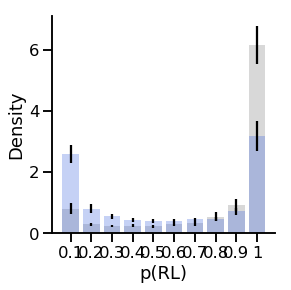

In [146]:
fig, ax = plt.subplots(1,1,  figsize=(4,4))

ax.bar(np.arange(0,10), df_summary.loc[df_summary[10] == 'Saline'].iloc[:,:-1].astype(float).mean(axis=0), yerr=df_summary.loc[df_summary[10] == 'Saline'].iloc[:,:-1].astype(float).sem(axis=0),color='grey', alpha=0.3)
ax.bar(np.arange(0,10), df_summary.loc[df_summary[10] == 'NR2B'].iloc[:,:-1].astype(float).mean(axis=0), yerr=df_summary.loc[df_summary[10] == 'NR2B'].iloc[:,:-1].astype(float).sem(axis=0) ,color='royalblue', alpha=0.3)
sns.despine()
plt.ylabel('Density')
plt.xlabel('p(RL)')
plt.xticks(np.arange(10),[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.savefig(save_path+'Fig 2. histogram.svg', dpi=300, bbox_inches='tight') 
df_summary.to_csv(save_path+'histogram.csv')

In [13]:
# all_data.drop(columns=['Delay_OFF','L_s','C_s','Response_ON','day','LL'],inplace=True)
# all_data['drug'] = np.where(all_data['drug']==0,'Rest',all_data['drug'])
# all_data['drug'] = np.where(all_data['drug']=='0','Rest',all_data['drug'])
# all_data = all_data.loc[(all_data.subject!= 'C28')&(all_data.subject!= 'C34')]
file_name = 'drug_experiments_df'
# all_data.to_csv(save_path+file_name+'.csv')
all_data = pd.read_csv(save_path+file_name+'.csv')

In [12]:
# full_fit.at[32, 't11']+=0.08
# full_fit = full_fit.loc[(full_fit.subject!= 'C28')&(full_fit.subject!= 'C34')]
file_name = 'drug_experiments_fit'
# full_fit.to_csv(save_path+file_name+'.csv')
full_fit = pd.read_csv(save_path+file_name+'.csv')

#### **Parameter fit**

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

drug v.s. Saline: t-test paired samples with Bonferroni correction, P_val=1.389e-02 stat=-3.739e+00
Saline v.s. 0: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=-1.009e+00
drug v.s. 0: t-test paired samples with Bonferroni correction, P_val=2.579e-02 stat=-3.345e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

drug v.s. Saline: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=5.189e-01
Saline v.s. 0: t-test paired samples with Bonferroni correction, P_val=7.117e-01 stat=-1.266e+00
drug v.s. 0: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=-8.008e-01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1

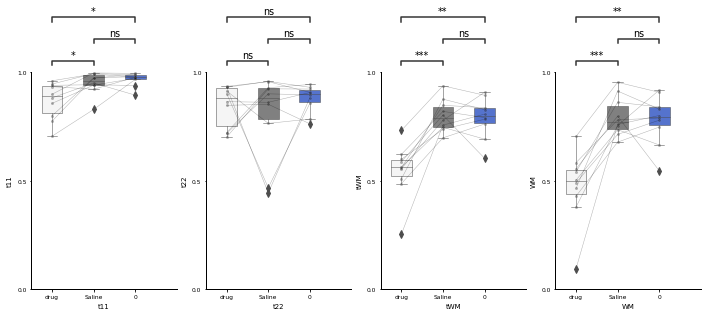

In [14]:
fig, ax = plt.subplots(1,4,  figsize=(12,4))

i=0
for y in ['t11','t22','tWM','WM']:
#     sns.boxplot(x='drug',y=full_fit[y].astype(float), data=full_fit, palette=['royalblue','grey','whitesmoke'],order=['drug','Saline','0'],ax=ax[i], linewidth=1)
#     sns.lineplot(x="drug", y=full_fit[y].astype(float),data=full_fit, hue='subject', ax=ax[i], linewidth=1.5, palette='binary',marker='o',legend=False,markersize=3)
    
    palette = sns.color_palette(['black'], len(full_fit.subject.unique()))
    sns.lineplot(x="drug", y=full_fit[y].astype(float),data=full_fit, hue='subject',  alpha=0.3, ax=ax[i], linewidth=0.5, markeredgewidth = 0.2,palette=palette,marker='o',legend=False,markersize=3)
    sns.boxplot(x='drug',y=full_fit[y].astype(float), data=full_fit, width=0.5, palette=['whitesmoke','grey','royalblue'],ax=ax[i], linewidth=0.5)

    ax[i].set_xlabel(y)
    ax[i].set_xlim(-0.5,3)
    ax[i].set_ylim(0,1)
    ax[i].set_xticks([0,1,2],['NR2B','Saline','Rest'])
    ax[i].locator_params(nbins=3)

    plt.legend([],[], frameon=False)
    if y == 'alfa':
        ax[3].set_ylim(2,3)
    add_stat_annotation(ax[i], data=full_fit, x='drug', y=y,
                        box_pairs=[("Saline", "drug"),("Saline", "0"),("0", "drug")],
                        test='t-test_paired', text_format='star', loc='outside', verbose=1)
    i+=1
sns.despine()
plt.savefig(save_path+'Fig 2. pharmacology_summary.svg', dpi=300, bbox_inches='tight') 

In [ ]:
H=4
V=4
for animal in all_data.subject.unique():
    # animal = 'E11'
    new_df_real = all_data.loc[(all_data.subject==animal)&(all_data.drug!='Rest')]
    
    for session in new_df_real.session.unique():
        print(session)
        temp_df = new_df_real.loc[(new_df_real['session'] == session)]
        
        temp_df['accuracy'] = compute_window_centered(temp_df, 20,'hit')
        temp_df['repeat_choice'] = compute_window_centered(temp_df, 20,'repeat')
    
        fig, axes = plt.subplots(1,2, figsize=(3*H,V))
        plt.title(str(animal) + ' ' + str(session) + ' ' + str(temp_df['drug'].iloc[0]))
        sns.lineplot(x='trial',y='accuracy',data=temp_df, ax= axes[0], color='darkgreen', label='Accuracy')
        sns.lineplot(x='trial',y='repeat_choice',data=temp_df, ax= axes[0], color='indigo', label= 'Repeating bias')

        sns.lineplot(x='trial',y='WM',data=temp_df, ax= axes[1], color='black',alpha=0.2, label='pWM')

        axes[0].set_ylabel('Running percentage')
        axes[0].set_xlabel('Trial index')
        axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),ncol=2)

        axes[1].set_ylabel('State probabilities')
        axes[1].set_xlabel('Trial index')
        axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),ncol=2)

        print('Total trials for WM: ', temp_df.loc[(temp_df["WM"]>0.5)]["stim"].count()/temp_df["stim"].count())
        print('Total trials for RL: ', temp_df.loc[(temp_df["RL"]>0.5)]["stim"].count()/temp_df["stim"].count())

        sns.despine()
        # plt.savefig(save_path+'/Fig 2. '+animal+'_'+str(temp_df['drug'].iloc[0])+'_'+str(session)+'.svg', dpi=300, bbox_inches='tight')   
        plt.show()

    # ------------ Line plots of delay versus things ----------
        fig, axes = plt.subplots(1,2, figsize=(2*H,V))
        df_results = pd.DataFrame()
        df_results['hit'] = temp_df['hit'].mean()
        df_results.reset_index(inplace=True)
        sns.lineplot(x='delays',y='hit',data=temp_df, ax= axes[0], color='darkgreen', label='Accuracy')
        axes[0].set_ylim(0.4,1)
        axes[0].set_ylabel('Accuracy')
        axes[0].hlines(y=0.5, xmin=0,xmax=10,linestyle=':')

        df_results = pd.DataFrame()
        df_results['repeat_choice'] = 0.5* temp_df.loc[temp_df['repeat_choice_side']==1].groupby(['delays'])['hit'].count()/temp_df.loc[temp_df.choices == -1].groupby(['delays'])['hit'].count() + 0.5*temp_df.loc[temp_df['repeat_choice_side']==2].groupby(['delays'])['hit'].count()/temp_df.loc[temp_df.choices == 1].groupby(['delays'])['hit'].count()

        df_results.reset_index(inplace=True)        
        sns.lineplot(x='delays',y='repeat_choice',data=temp_df, ax= axes[1], color='indigo', label= 'Repeating bias')
        sns.despine()
        axes[1].set_ylim(0.4,1)
        axes[1].set_ylabel('Repeating bias')
        axes[1].hlines(y=0.5, xmin=0,xmax=10,linestyle=':')  
        # plt.savefig(save_path+'/Fig 2. '+animal+'_'+str(temp_df['drug'].iloc[0])+'_'+str(session)+'_descriptive.svg', dpi=300, bbox_inches='tight')   
        plt.show()
        
#     # ------------ Histogram ----------
#         fig, axes = plt.subplots(1,2, figsize=(2*H,V))
#         df_results = pd.DataFrame()
#         df_results['hit'] = temp_df['hit'].mean()
#         df_results.reset_index(inplace=True)
#         sns.lineplot(x='delays',y='hit',data=temp_df, ax= axes[0], color='darkgreen', label='Accuracy')
#         axes[0].set_ylim(0.4,1)
#         axes[0].set_ylabel('Accuracy')
#         axes[0].hlines(y=0.5, xmin=0,xmax=10,linestyle=':')

#         df_results = pd.DataFrame()
#         df_results['repeat_choice'] = 0.5* temp_df.loc[temp_df['repeat_choice_side']==1].groupby(['delays'])['hit'].count()/temp_df.loc[temp_df.choices == -1].groupby(['delays'])['hit'].count() + 0.5*temp_df.loc[temp_df['repeat_choice_side']==2].groupby(['delays'])['hit'].count()/temp_df.loc[temp_df.choices == 1].groupby(['delays'])['hit'].count()

#         df_results.reset_index(inplace=True)        
#         sns.lineplot(x='delays',y='repeat_choice',data=temp_df, ax= axes[1], color='indigo', label= 'Repeating bias')
#         sns.despine()
#         axes[1].set_ylim(0.4,1)
#         axes[1].set_ylabel('Repeating bias')
#         axes[1].hlines(y=0.5, xmin=0,xmax=10,linestyle=':')  
#         plt.savefig(save_path+'/Fig 2. '+animal+'_'+str(temp_df['drug'].iloc[0])+'_'+str(session)+'_hist.svg', dpi=300, bbox_inches='tight')  
        

In [ ]:
df_results = pd.DataFrame()
df= all_data

fig, ax = plt.subplots(1,1,  figsize=(3.5,4),sharey=True)

df_results = pd.DataFrame()
# df_results['accuracy'] = df.groupby(['subject','reward_side','C+_-1','drug'])['hit'].mean()
df_results['accuracy'] = df.loc[(df['drug']=='Saline')|(df['drug']=='NR2B')|(df['drug']=='0')].groupby(['subject','drug'])['hit'].mean()
df_results.reset_index(inplace=True)

df_results['drug'] = pd.Categorical(df_results['drug'], categories=['0','Saline', 'NR2B'], ordered=True)

# sns.violinplot(x='drug',y='accuracy', data=df_results,linewidth=1.5, ax=ax,  palette=['whitesmoke','grey','royalblue'],order=['0','Saline','NR2B'],inner="box").set_alpha(0.4)
# sns.lineplot(x="drug", y="accuracy", hue='subject',data=df_results, ax=ax,  linewidth=1.5, palette='Greys',marker='o',alpha=0.3,ci=0,legend=False,markersize=4)

palette = sns.color_palette(['black'], len(df_results.subject.unique()))
sns.lineplot(x="drug", y="accuracy",data=df_results, hue='subject', alpha=0.3, ax=ax, linewidth=0.5, markeredgewidth = 0.2,palette=palette,marker='o',legend=False,markersize=3)
sns.boxplot(x='drug',y="accuracy", data=df_results, width=0.5, palette=['whitesmoke','grey','royalblue'],ax=ax, linewidth=1)

ax.set_xlabel('Treatment')
ax.set_ylabel('Accuracy')
ax.set_ylim(0.45,1)
ax.set_xlim(-0.5,2.5)
ax.hlines(y=0.5,xmin=-0.5,xmax=2.5,linestyle=':')
plt.xticks([0,1,2],['Rest','Saline','NR2B'])
ax.legend(loc='lower right', ncol=2)
sns.despine()

add_stat_annotation(ax, data=df_results, x='drug', y='accuracy',
                    box_pairs=[( "0",'Saline'),( "Saline",'NR2B'),( "0",'NR2B')],
                    test='t-test_paired', text_format='star', loc='outside', verbose=2)

plt.locator_params(nbins=3)
plt.legend(handles='', ncol=2).get_frame().set_linewidth(0.0)
plt.savefig(save_path+'/Fig 2. Accuracy vs drug.svg', dpi=300, bbox_inches='tight')   

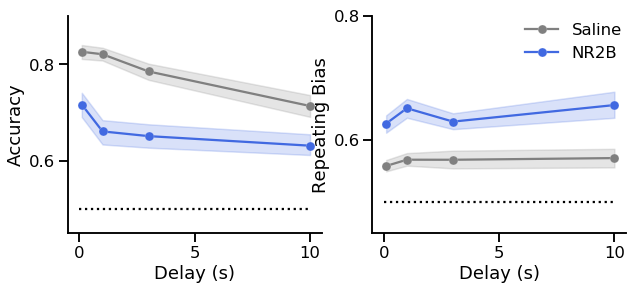

In [16]:
fig, ax = plt.subplots(1,2, figsize=(10, 4),sharey=False)

df= all_data

df_results = pd.DataFrame()
df_results['accuracy'] = df.groupby(['subject','drug','delays'])['hit'].mean()
df_results.reset_index(inplace=True)

sns.lineplot(x='delays',y='accuracy',data=df_results[df_results['drug']=='0'],markeredgewidth = 0.2,marker='o',ax=ax[0], color='black',ci=67)
sns.lineplot(x='delays',y='accuracy',data=df_results[df_results['drug']=='Saline'],markeredgewidth = 0.2,marker='o',ax=ax[0], color='grey',ci=67)
sns.lineplot(x='delays',y='accuracy',data=df_results[df_results['drug']=='NR2B'],markeredgewidth = 0.2,marker='o',ax=ax[0], color='royalblue',ci=67)

ax[0].set_ylim(0.45,0.9)

ax[1].set_xlabel('Delay (s)')
ax[0].set_xlabel('Delay (s)')
ax[0].tick_params(axis='y', colors='black')
ax[0].yaxis.label.set_color("black")
ax[0].hlines(xmin=0, xmax=10, y=0.5, linestyle=':')

df_results = pd.DataFrame()

df_results['prob_repeat'] = 0.5* df.loc[df['repeat_choice_side']==1].groupby(['drug','subject','delays'])['hit'].count()/df.loc[df.choices == -1].groupby(['drug','subject','delays'])['hit'].count() + 0.5*df.loc[df['repeat_choice_side']==2].groupby(['drug','subject','delays'])['hit'].count()/df.loc[df.choices == 1].groupby(['drug','subject','delays'])['hit'].count()
df_results.reset_index(inplace=True)

sns.lineplot(x='delays',y='prob_repeat',data=df_results[df_results['drug']=='0'],markeredgewidth = 0.2,marker='o',ax=ax[1], color='black',ci=67, label='Rest')
sns.lineplot(x='delays',y='prob_repeat',data=df_results[df_results['drug']=='Saline'],markeredgewidth = 0.2,marker='o',ax=ax[1], color='grey',ci=67, label='Saline')
sns.lineplot(x='delays',y='prob_repeat',data=df_results[df_results['drug']=='NR2B'],markeredgewidth = 0.2,marker='o',ax=ax[1], color='royalblue',ci=67, label='NR2B')

ax[0].set_ylabel('Accuracy')

ax[1].set_ylabel('Repeating Bias')
ax[1].set_ylim(0.45,0.8)
ax[1].hlines(xmin=0, xmax=10, y=0.5, linestyle=':')
ax[1].xaxis.label.set_color('black')
ax[1].tick_params(axis='y', colors='black')
ax[1].yaxis.label.set_color("black")
ax[1].locator_params(nbins=3)
ax[0].locator_params(nbins=3)
# ------------- Now same but with the modelled data
# df= all_data_model

# df_results = pd.DataFrame()
# df_results['accuracy'] = df.groupby(['subject','drug','delays'])['hit'].mean()
# df_results.reset_index(inplace=True)

# sns.lineplot(x='delays',y='accuracy',data=df_results[df_results['drug']=='0'],marker='o',ax=ax[0], color='black',ci=67)
# sns.lineplot(x='delays',y='accuracy',data=df_results[df_results['drug']=='Saline'],marker='o',ax=ax[0], color='grey',ci=67)
# sns.lineplot(x='delays',y='accuracy',data=df_results[df_results['drug']=='NR2B'],marker='o',ax=ax[0], color='royalblue',ci=67)

# ax[0].set_ylim(0.4,0.9)

# ax[1].set_xlabel('Delay (s)')
# ax[0].set_xlabel('Delay (s)')
# ax[0].tick_params(axis='y', colors='black')
# ax[0].yaxis.label.set_color("black")
# ax[0].hlines(xmin=0, xmax=10, y=0.5, linestyle=':')

# df_results = pd.DataFrame()

# df_results['prob_repeat'] = 0.5* df.loc[df['repeat_choice_side']==1].groupby(['drug','subject','delays'])['hit'].count()/df.loc[df.choices == -1].groupby(['drug','subject','delays'])['hit'].count() + 0.5*df.loc[df['repeat_choice_side']==2].groupby(['drug','subject','delays'])['hit'].count()/df.loc[df.choices == 1].groupby(['drug','subject','delays'])['hit'].count()
# df_results.reset_index(inplace=True)

# sns.lineplot(x='delays',y='prob_repeat',data=df_results[df_results['drug']=='0'],marker='o',ax=ax[1], color='black',ci=95)
# sns.lineplot(x='delays',y='prob_repeat',data=df_results[df_results['drug']=='Saline'],marker='o',ax=ax[1], color='grey',ci=67)
# sns.lineplot(x='delays',y='prob_repeat',data=df_results[df_results['drug']=='NR2B'],marker='o',ax=ax[1], color='royalblue',ci=67)

# ax[0].set_ylabel('Accuracy')

# ax[1].set_ylabel('Repeating Bias')
# ax[1].set_ylim(0.4,0.9)
# ax[1].hlines(xmin=0, xmax=10, y=0.5, linestyle=':')
# ax[1].xaxis.label.set_color('black')
# ax[1].tick_params(axis='y', colors='black')
# ax[1].yaxis.label.set_color("black")

sns.despine()
# plt.suptitle('History biases with and without drug')
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0).get_frame().set_linewidth(0.0)
plt.savefig(save_path+'/Fig 2. accuracy and repeated responses behavioral vs delay.svg', bbox_inches='tight') 

In [15]:
all_data = all_data.loc[(all_data.subject!='C28')&(all_data.subject!='C34')]

In [176]:
df_results = pd.DataFrame()
# df_results['prob_repeat'] = df.groupby(['subject','drug','delays'])['repeat'].mean()
df_results['prob_repeat'] = 0.5* df.loc[df['repeat_choice_side']==1].groupby(['drug','subject','delays'])['hit'].count()/df.loc[df.choices == -1].groupby(['drug','subject','delays'])['hit'].count() + 0.5*df.loc[df['repeat_choice_side']==2].groupby(['drug','subject','delays'])['hit'].count()/df.loc[df.choices == 1].groupby(['drug','subject','delays'])['hit'].count()

df_results.reset_index(inplace=True)

model = ols('prob_repeat ~  delays + drug + delays:drug', data=df_results).fit()
sm.stats.anova_lm(model, typ=2)

sum_sq     df          F        PR(>F)
drug         0.118648    2.0  31.301196  1.461408e-11
delays       0.001302    1.0   0.686827  4.089775e-01
delays:drug  0.000493    2.0   0.129981  8.782421e-01
Residual     0.216060  114.0        NaN           NaN

In [ ]:
md = smf.mixedlm("prob_repeat ~ delays + drug + delays:drug", data = df_results, groups=df_results["subject"])
mdf = md.fit()
print(mdf.summary())

In [154]:
df_results = pd.DataFrame()
df_results['accuracy'] = df.groupby(['subject','drug','delays'])['hit'].mean()
df_results.reset_index(inplace=True)

model = ols('accuracy ~  delays + drug + delays:drug', data=df_results).fit()
sm.stats.anova_lm(model, typ=2)

sum_sq     df          F        PR(>F)
drug         0.436091    2.0  40.538423  5.033269e-14
delays       0.151876    1.0  28.236344  5.390246e-07
delays:drug  0.006167    2.0   0.573259  5.653019e-01
Residual     0.613176  114.0        NaN           NaN

No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

0 v.s. Saline: t-test paired samples with Bonferroni correction, P_val=6.175e-01 stat=1.364e+00
Saline v.s. NR2B: t-test paired samples with Bonferroni correction, P_val=1.122e-03 stat=-5.513e+00
0 v.s. NR2B: t-test paired samples with Bonferroni correction, P_val=1.951e-02 stat=-3.521e+00


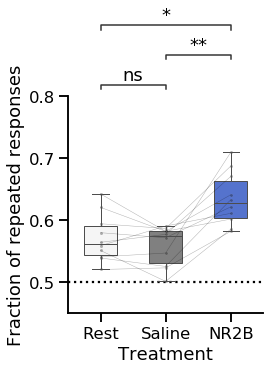

In [18]:
fig, ax = plt.subplots(1,1, figsize=(3.5, 4),sharey=False)

df_results = pd.DataFrame()
df= all_data
df_results['prob_repeat'] = 0.5* df.loc[df['repeat_choice_side']==1].groupby(['drug','subject'])['hit'].count()/df.loc[df.choices == -1].groupby(['drug','subject'])['hit'].count() + 0.5*df.loc[df['repeat_choice_side']==2].groupby(['drug','subject'])['hit'].count()/df.loc[df.choices == 1].groupby(['drug','subject'])['hit'].count()
df_results.reset_index(inplace=True)

df_results['drug'] = pd.Categorical(df_results['drug'], categories=['0','Saline', 'NR2B'], ordered=True)

# sns.violinplot(x='drug',y='prob_repeat', data=df_results,ax=ax,  linewidth=1.5, palette=['whitesmoke','grey','royalblue'],order=['0','Saline','NR2B']).set_alpha(0.4)
# sns.lineplot(x="drug", y="prob_repeat", hue='subject',data=df_results, ax=ax,  palette='Greys',marker='o',ci=0,legend=False,markersize=4)
palette = sns.color_palette(['black'], len(df_results.subject.unique()))
sns.lineplot(x="drug", y="prob_repeat",data=df_results, hue='subject', alpha=0.3, ax=ax, linewidth=0.5, markeredgewidth = 0.2,palette=palette,marker='o',legend=False,markersize=3)
sns.boxplot(x='drug',y="prob_repeat", data=df_results, width=0.5, palette=['whitesmoke','grey','royalblue'],ax=ax, linewidth=1)

ax.set_xlabel('Treatment')
ax.set_ylim(0.45,0.8)
ax.set_ylabel('Fraction of repeated responses')

ax.legend(loc='lower right', ncol=2)
ax.hlines(y=0.5,xmin=-0.5,xmax=2.5,linestyle=':')
sns.despine()

add_stat_annotation(ax, data=df_results, x='drug', y='prob_repeat',
                    box_pairs=[("Saline", "0"),("Saline", "NR2B"),("0", "NR2B")],
                    test='t-test_paired', text_format='star', loc='outside', verbose=2)
plt.legend([],[], frameon=False)
plt.xticks([0,1,2],['Rest','Saline','NR2B'])
plt.savefig(save_path+'/Fig 2. Repeated responses behavioral.svg', bbox_inches='tight') 

### **Trials**

In [40]:
def trials(row):
    val = 0
    val = np.around(row['trial']/row['total_trial'],1)
    return val

all_data['T'] = all_data.apply(trials, axis=1)

In [41]:
all_data['state'] = np.where(all_data.WM >0.5, 1, 0)

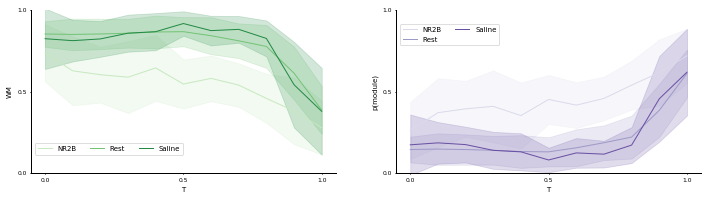

In [42]:
fig, ax = plt.subplots(1,2, figsize=(4*3, 3))

df_results = pd.DataFrame()
df_results['WM'] = all_data.loc[all_data.drug!='0'].groupby(['T','subject','drug'])['WM'].mean()
df_results.reset_index(inplace=True)

sns.lineplot(x = 'T', y='WM', data=df_results, hue='drug', palette='Greens', ci='sd',ax=ax[0])
ax[0].set_ylim(0,1)
ax[0].legend(loc='center left', ncol=3, bbox_to_anchor=(0, 0.15))
ax[0].locator_params(nbins=3)

df_results = pd.DataFrame()
df_results['RL'] = all_data.loc[all_data.drug!='0'].groupby(['T','subject','drug'])['RL'].mean()
df_results.reset_index(inplace=True)

sns.lineplot(x = 'T', y='RL', data=df_results, hue='drug', palette='Purples', ci='sd',ax=ax[1])
plt.ylim(0,1)
plt.legend(loc='center left', bbox_to_anchor=(0, 0.85),ncol=2)
ax[1].locator_params(nbins=3)
plt.ylabel('p(module)')
sns.despine()

In [ ]:
all_data.groupby(['drug','T'])['hit'].mean()

_________________________________
## Plot different things

In [ ]:
os.getcwd() 
os.chdir('C:/Users/Tiffany/Google Drive/WORKING_MEMORY/MODEL/HMM_wm_mice-main/figures/')

**Accuracy and repeating bias vs trial index**

In [23]:
all_data.loc[(all_data.subject == 'N24')&(all_data.session == 3)]

choices Delay_OFF                                                C_s  \
455       -1      None                                             [None]   
456       -1    0.9467  [1.4010000229, 1.5325000286, 1.638299942, 1.76...   
457       -1    0.9467  [1.4263999462, 1.5671000481, 1.8258999586, 1.9...   
458       -1    3.9367  [4.5581998825, 4.7042999268, 4.8269000053, 4.9...   
459       -1    0.9462                                             [None]   
..       ...       ...                                                ...   
769        1    3.9362                                     [4.6147999763]   
770       -1   10.9367                                             [None]   
771       -1    1.9362                                             [None]   
772        1    3.9367                       [4.5433998108, 4.8106999397]   
773        1    0.9467                       [1.3574999571, 1.4721000195]   

                                                   L_s Response_ON  stim  \
455  [1.801699996, 1.9580999613, 2.0729999542, 2.20...      0.7681    -1   
456         [1.2987999916, 2.5339999199, 2.8508999348]      1.0547     1   
457  [1.2944999933, 1.7108999491, 2.4737999439, 2.6...      1.0547     1   
458  [4.3017001152, 4.4113998413, 5.4713997841, 5.5...      4.0447     1   
459  [1.2238999605, 1.3596999645, 1.4967000484, 1.6...      1.0531    -1   
..                                                 ...         ...   ...   
769                                             [None]      4.0362    -1   
770      [11.2166996002, 11.3652000427, 11.5275001526]     11.0367     1   
771  [2.2822999954, 2.4203000069, 2.5611000061, 2.6...      2.0362    -1   
772                                             [None]      4.0367     1   
773                                             [None]      1.0467     1   

            day  session                                       past_choices  \
455  2020-11-06        3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
456  2020-11-06        3  [-1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
457  2020-11-06        3  [-1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
458  2020-11-06        3  [-1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
459  2020-11-06        3  [-1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0...   
..          ...      ...                                                ...   
769  2020-11-06        3  [1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0...   
770  2020-11-06        3  [0.0, 0.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0,...   
771  2020-11-06        3  [0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 1.0, 1.0, 1.0,...   
772  2020-11-06        3  [-1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 1.0, 1.0...   
773  2020-11-06        3  [1.0, -1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 1.0...   

                                          past_rewards  ...  delays  hit  \
455  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  ...     0.1    1   
456  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  ...     0.1    0   
457  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  ...     0.1    0   
458  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  ...     3.0    0   
459  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  ...     0.1    1   
..                                                 ...  ...     ...  ...   
769  [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, ...  ...     3.0    0   
770  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...  ...    10.0    0   
771  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  ...     1.0    1   
772  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  ...     3.0    1   
773  [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  ...     0.1    1   

     repeat  repeat_choice_side            WM        RL  streak  total_trial  \
455     NaN                   0  7.793644e-30  1.000000       0          319   
456     1.0                   1  3.832887e-04  0.999617      -1          319   
457     1.0                   1  5.513792e-03  0.994486      -2  

2021-03-19


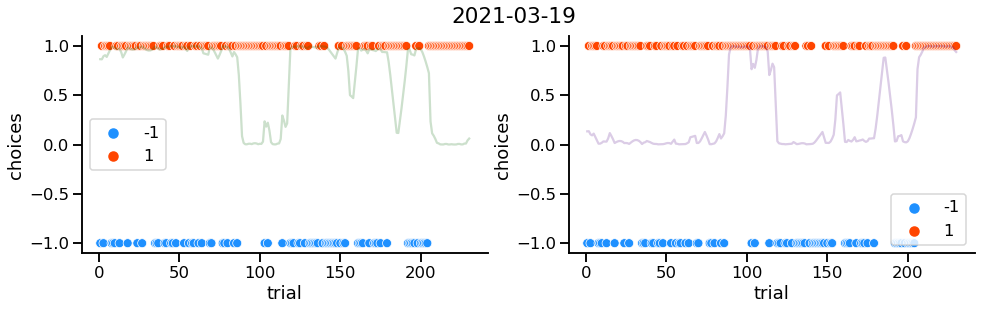

2021-03-21


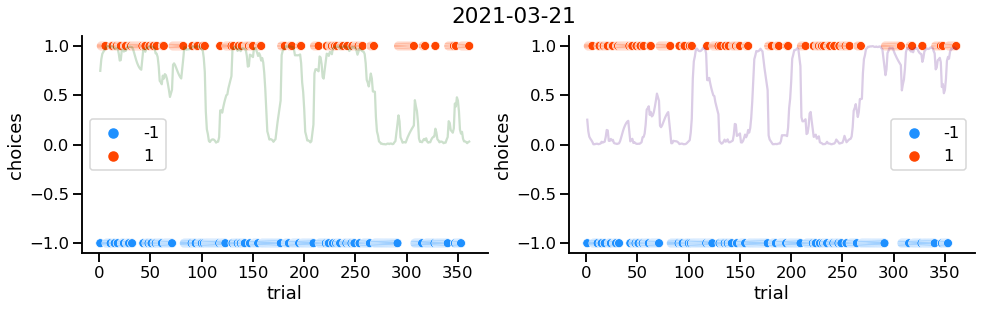

2021-03-22


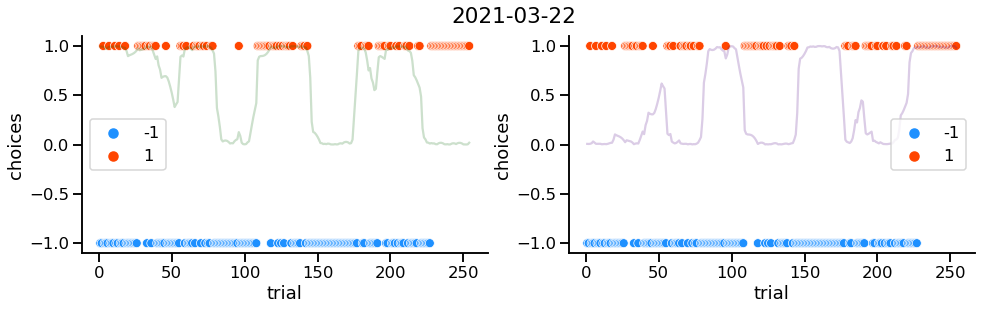

2021-03-23


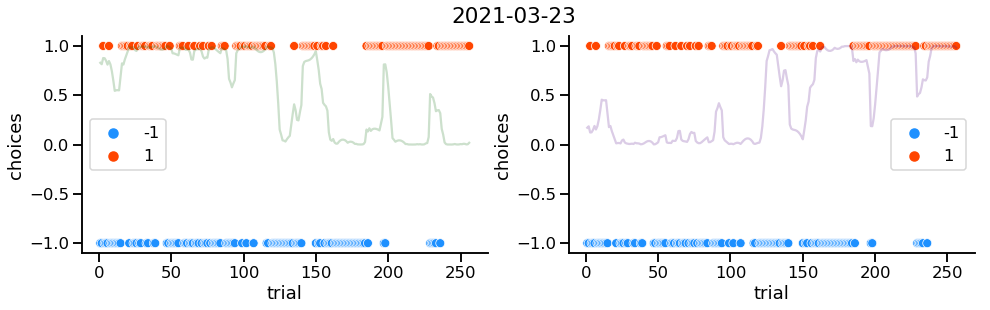

2021-03-24


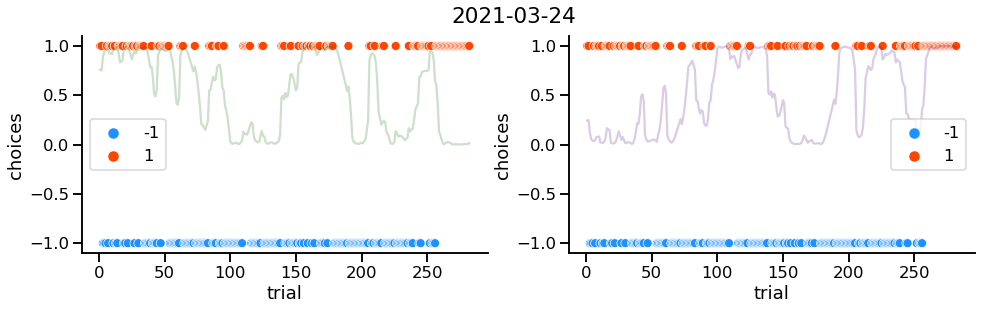

2021-03-26


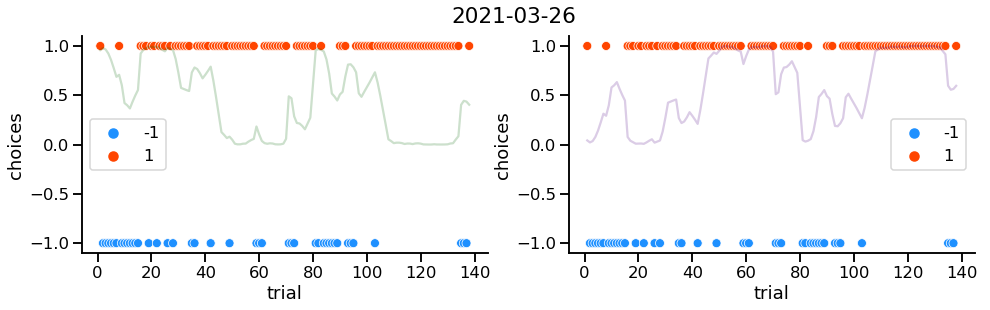

2021-03-27


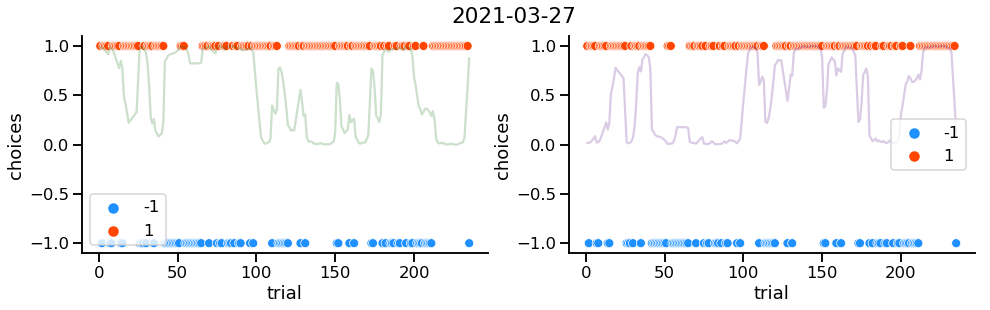

2021-03-28


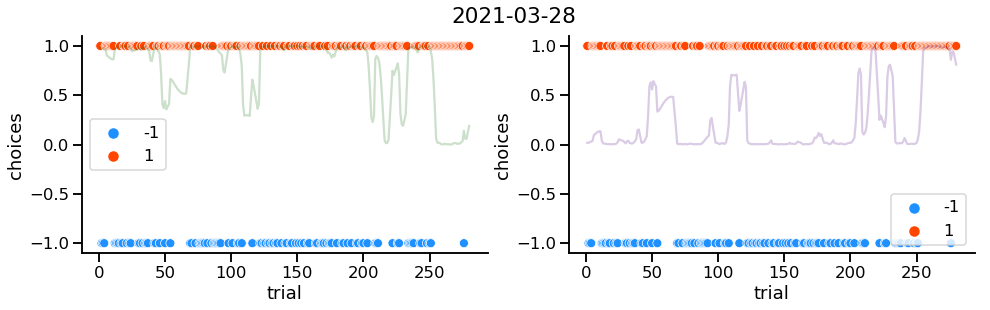

2021-03-29


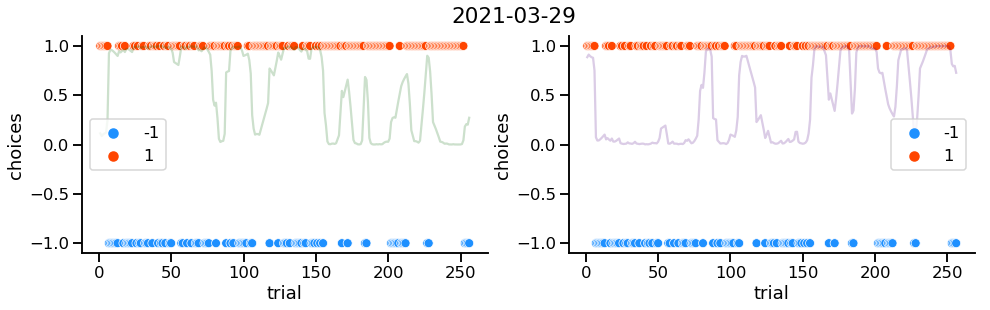

2021-03-30


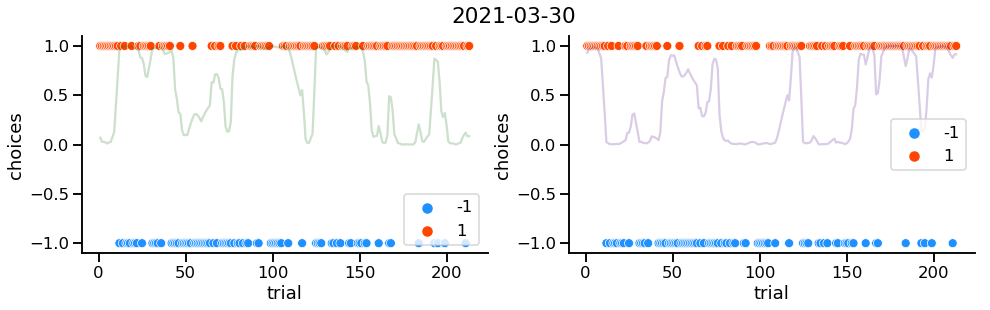

2021-03-31


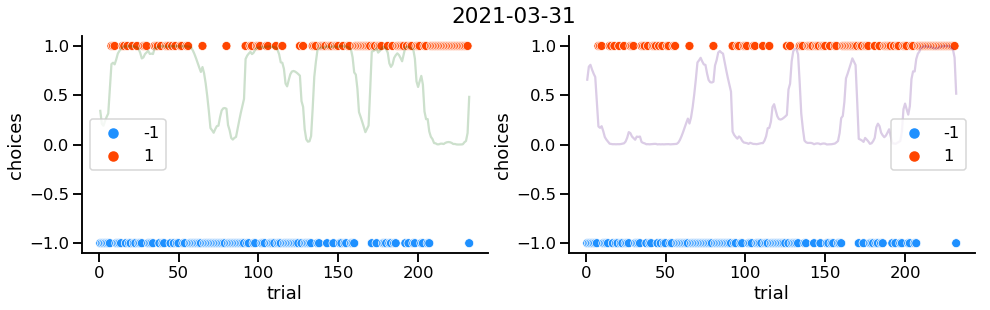

2021-04-01


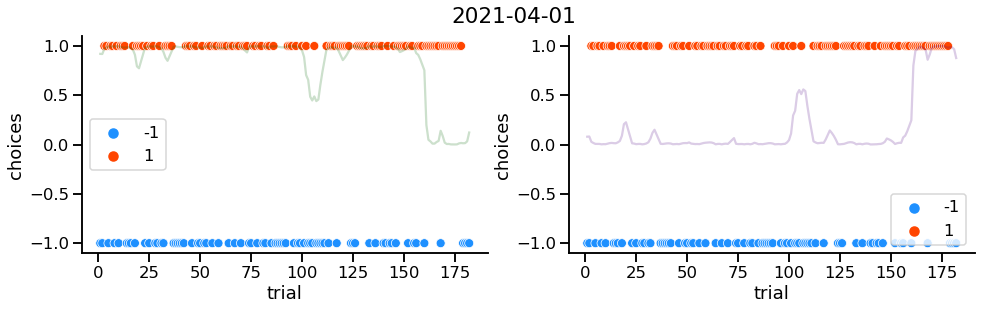

2021-04-02


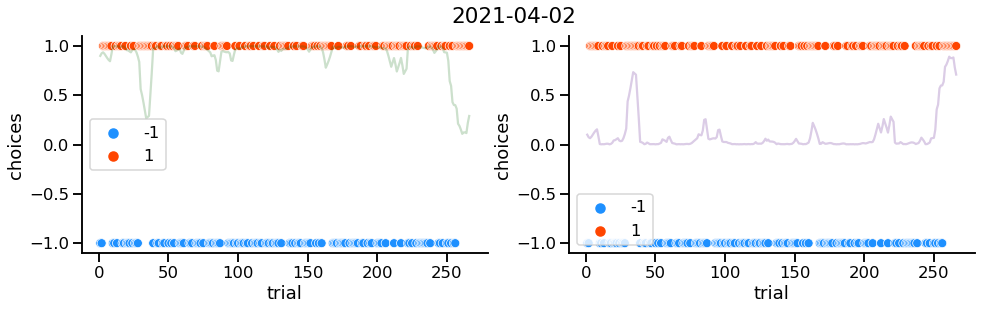

2021-04-03


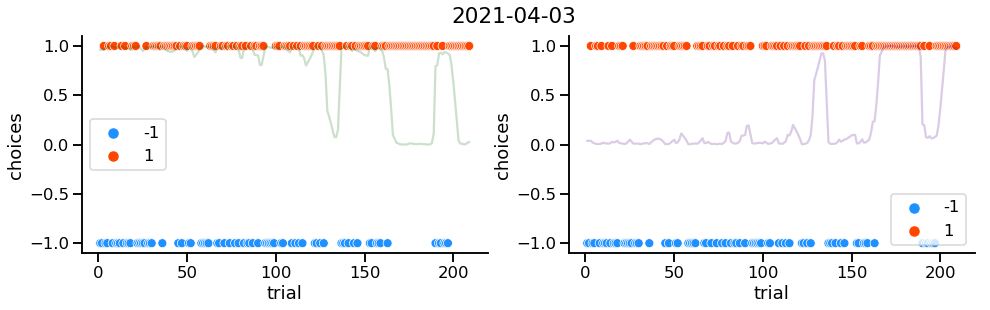

2021-04-04


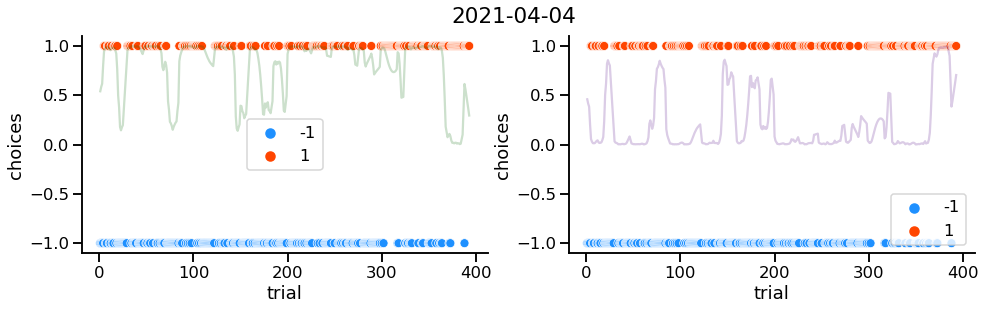

2021-04-06


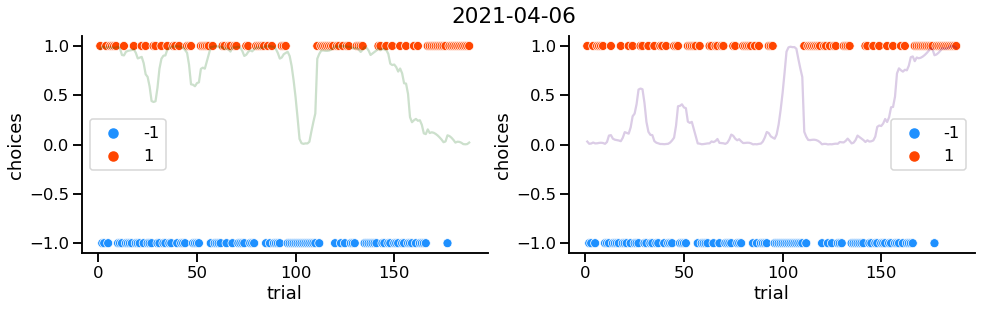

2021-04-07


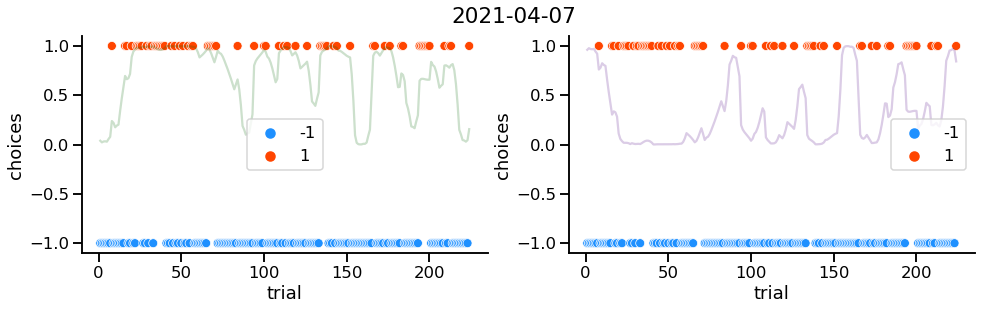

2021-04-08


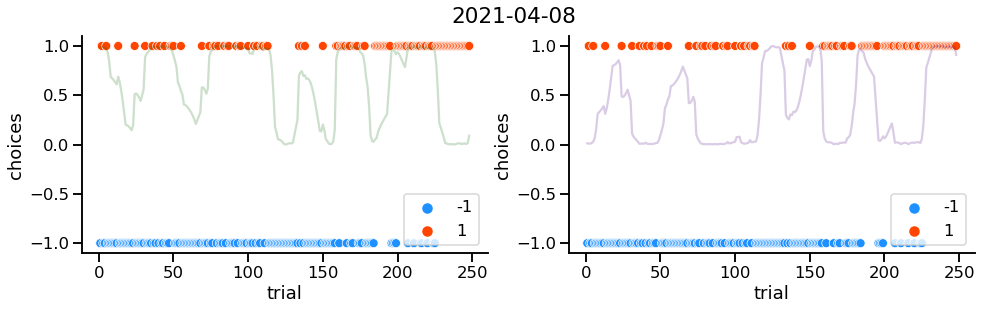

2021-04-09


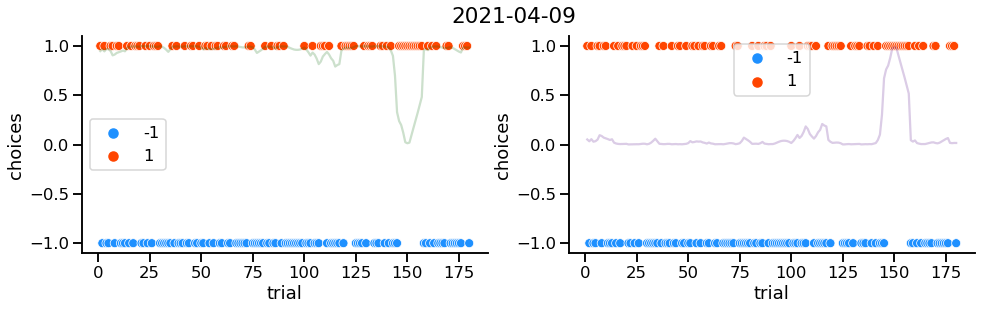

2021-04-10


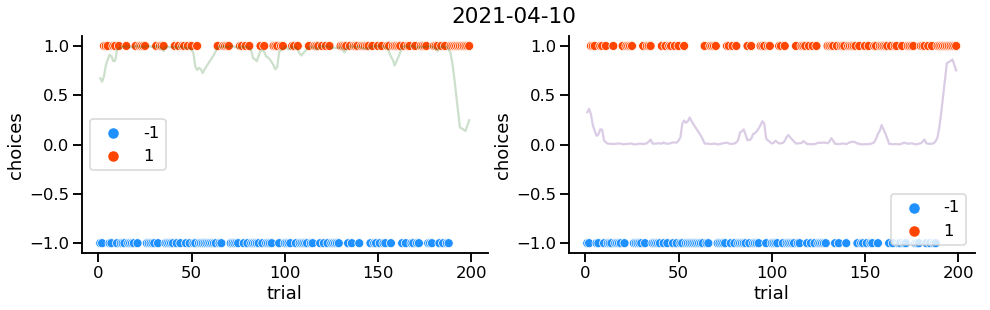

2021-04-12


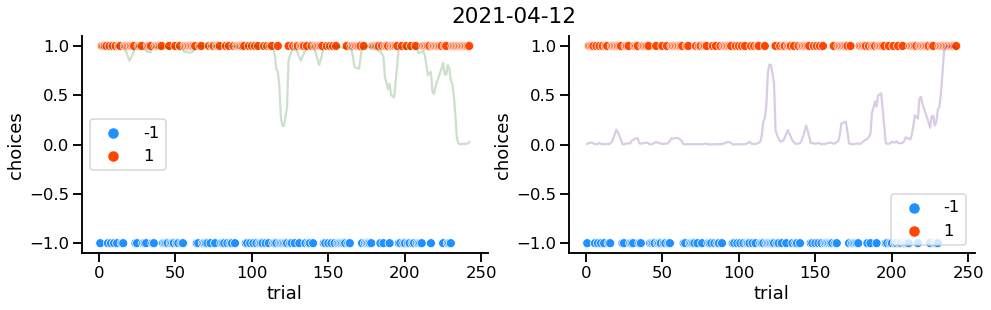

2021-04-13


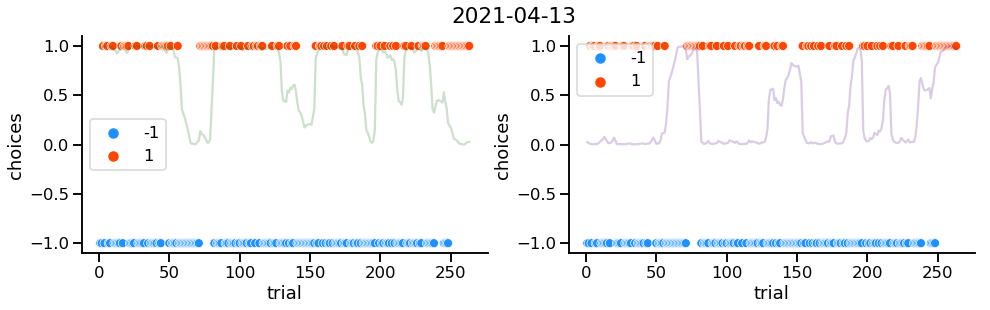

2021-04-14


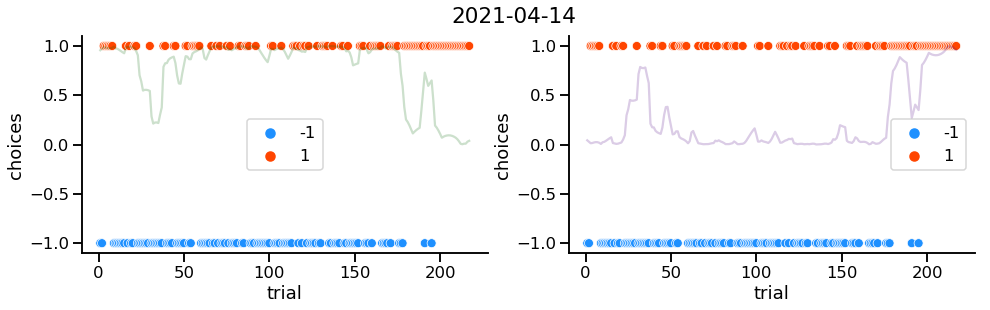

2021-04-15


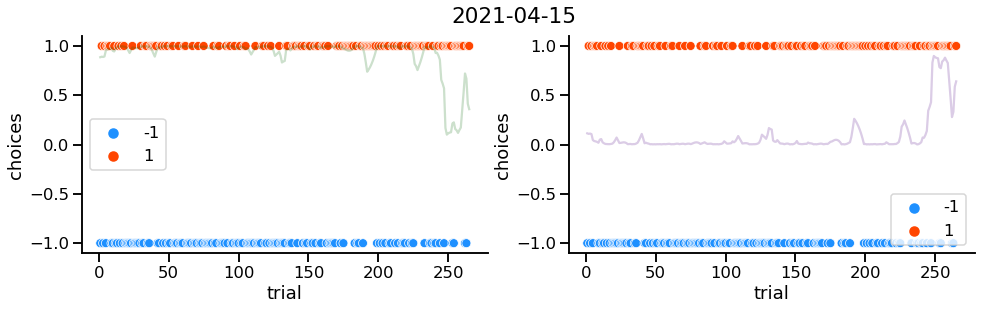

2021-04-17


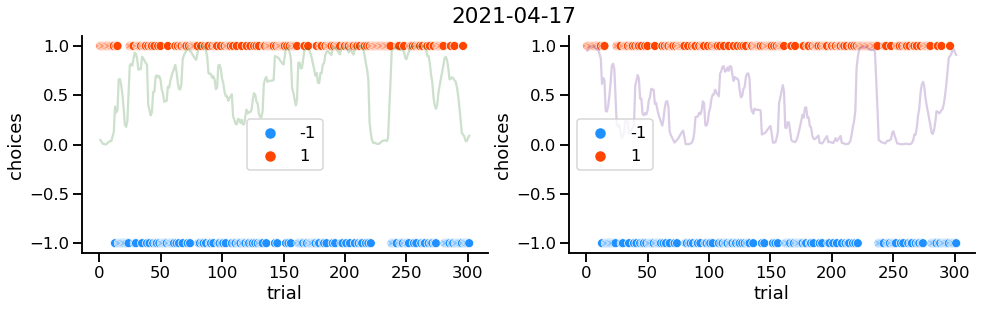

2021-05-02


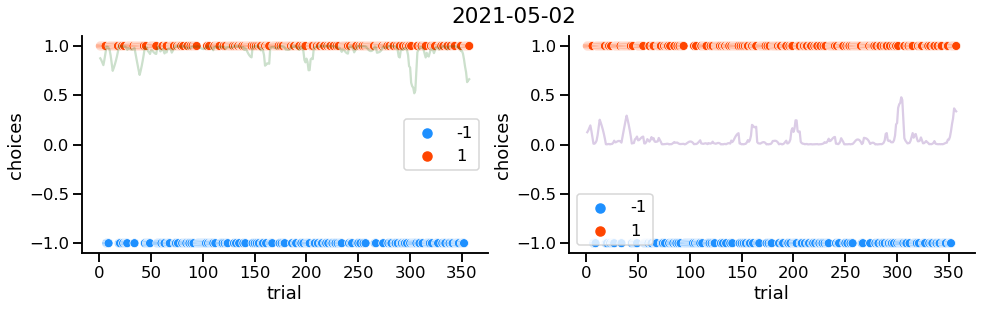

2021-05-03


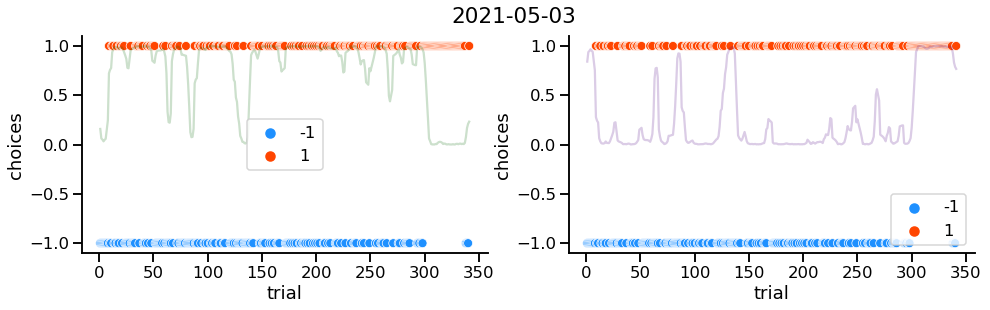

2021-05-04


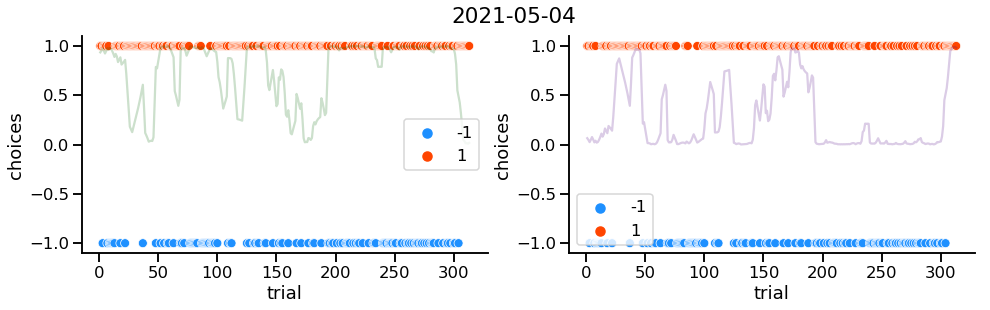

2021-05-05


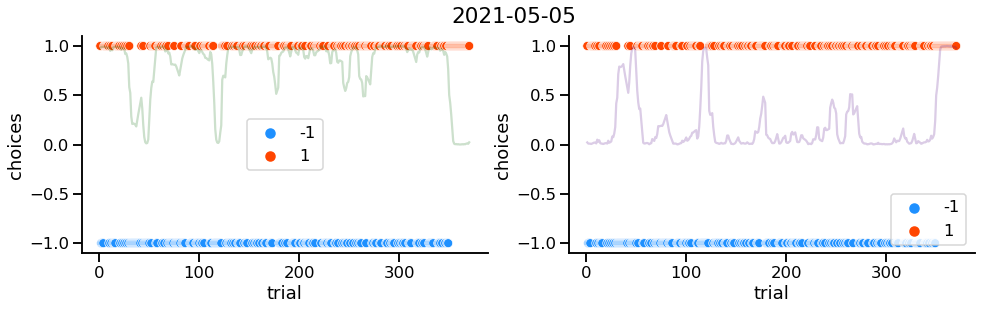

2021-05-06


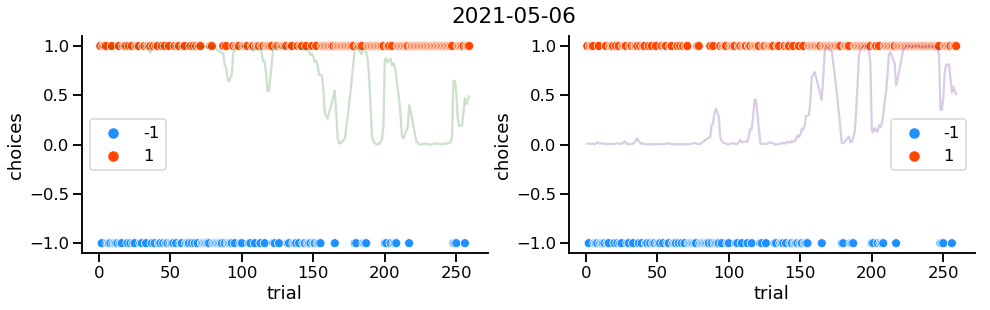

2021-05-07


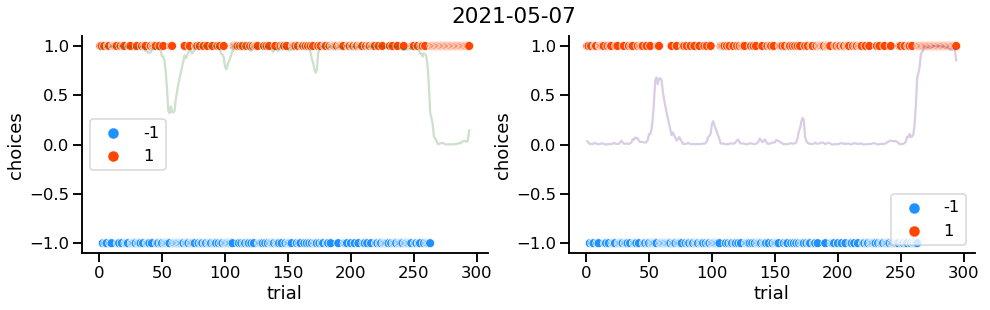

2021-05-08


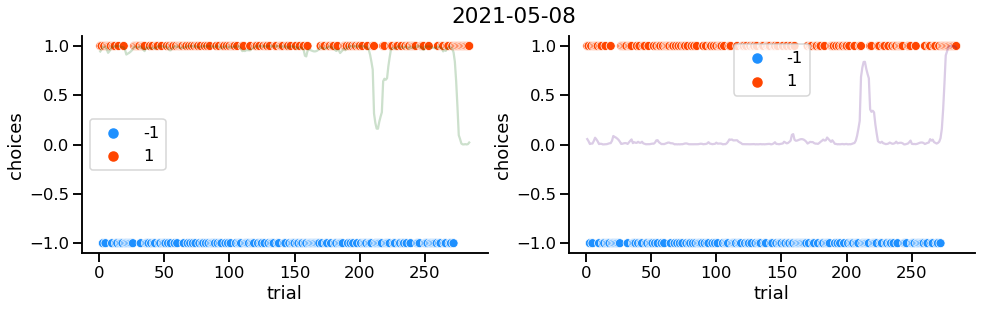

2021-05-09


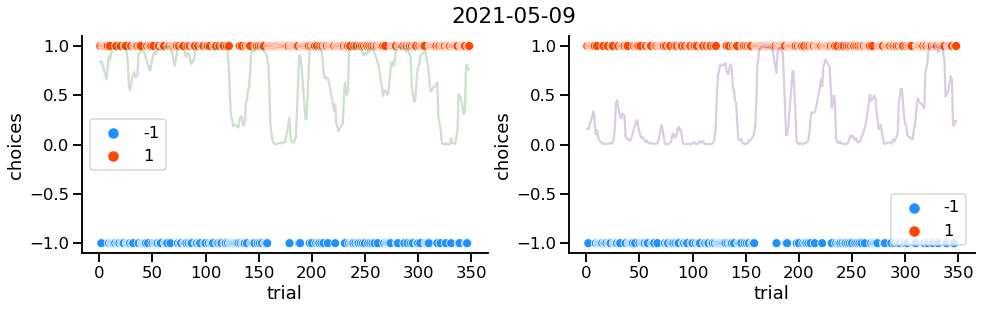

2021-05-10


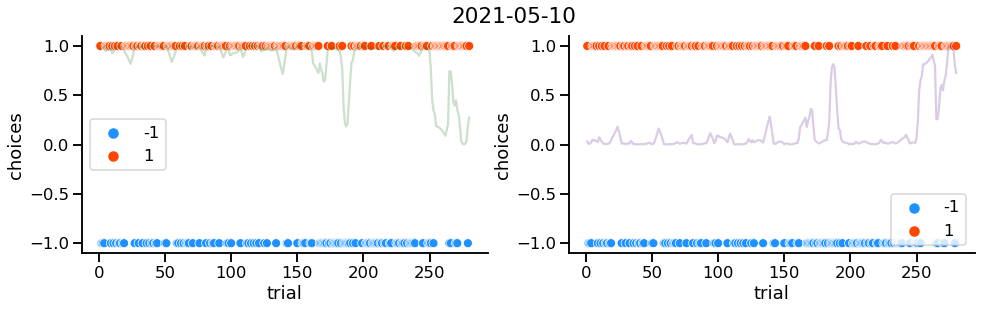

2021-05-11


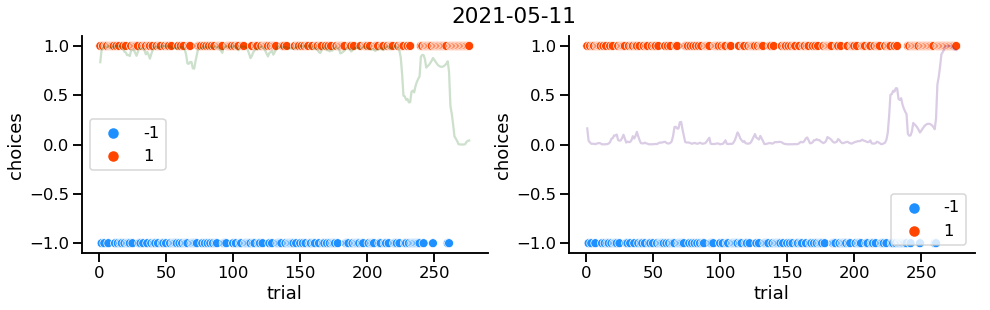

2021-05-12


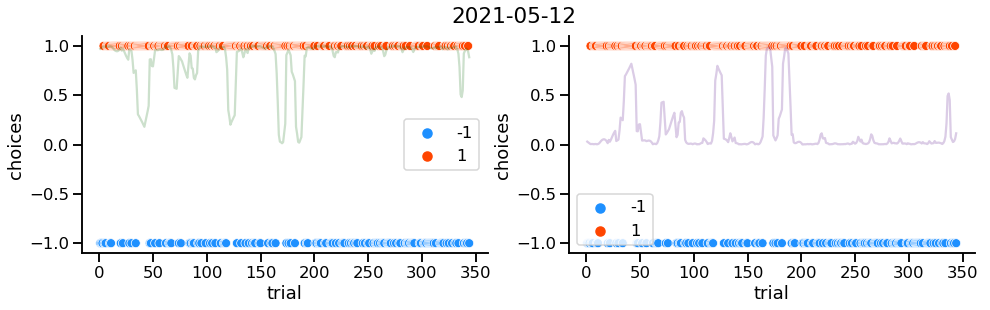

2021-05-13


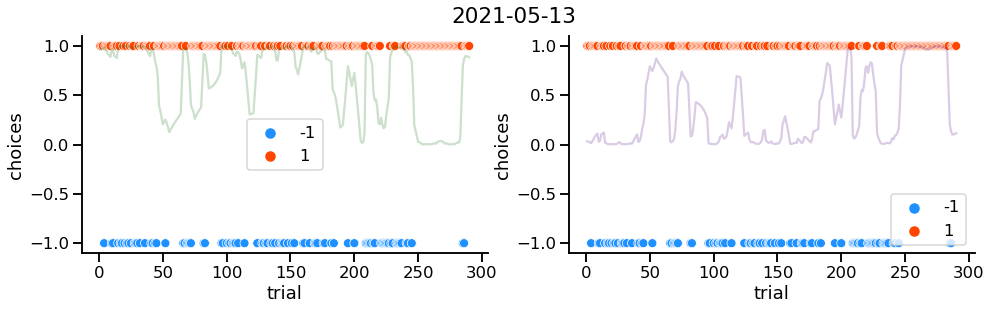

2021-05-14


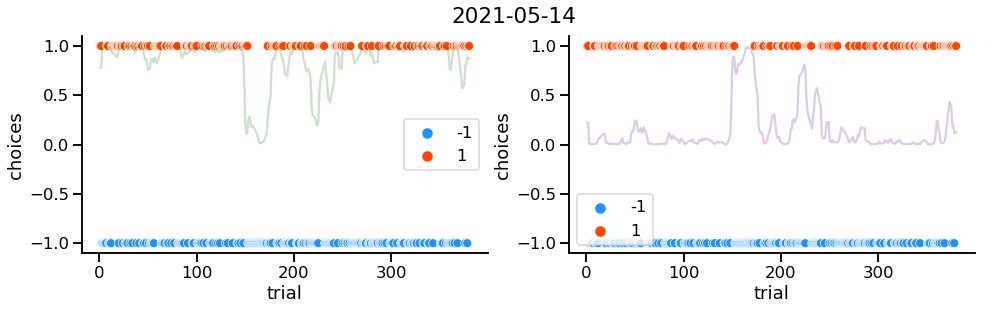

2021-05-15


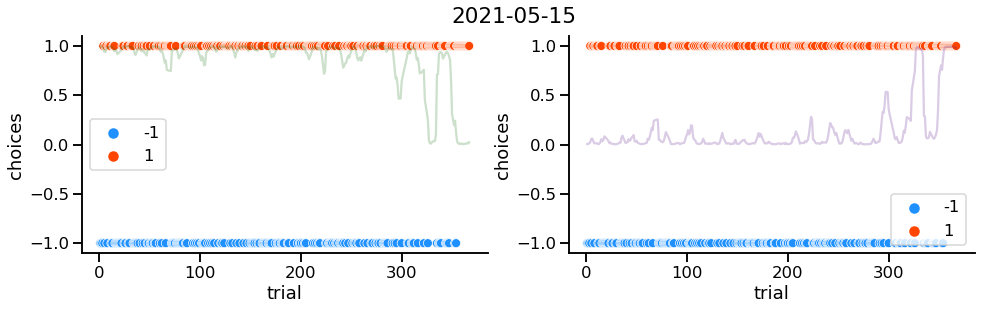

2021-05-16


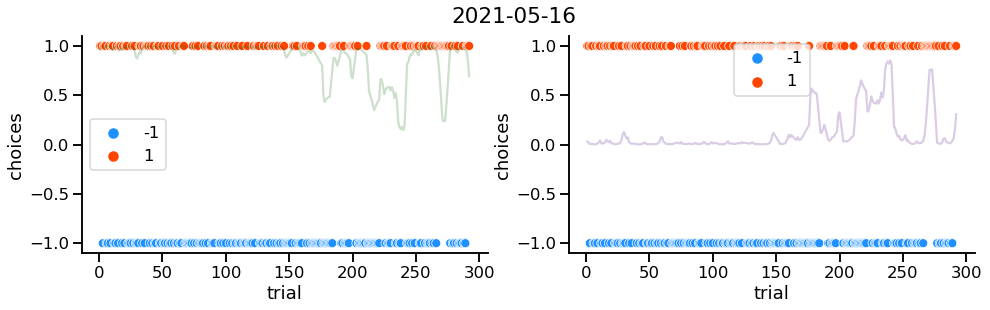

2021-05-17


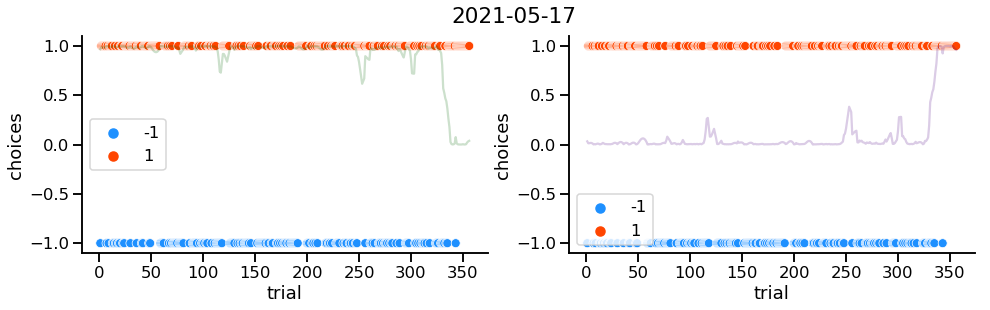

2021-05-18


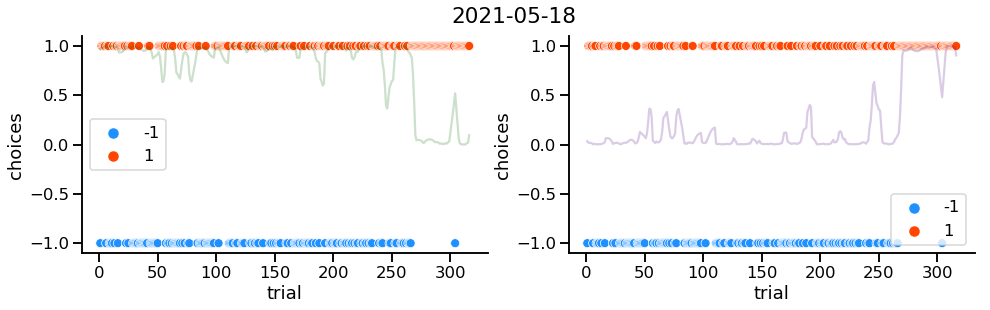

2021-05-19


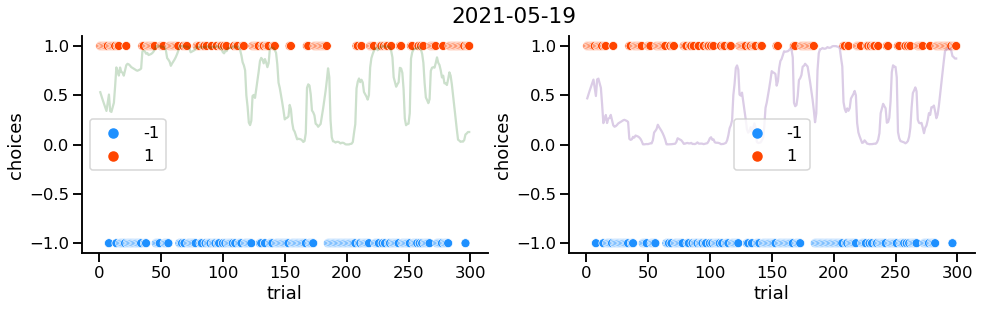

2021-05-20


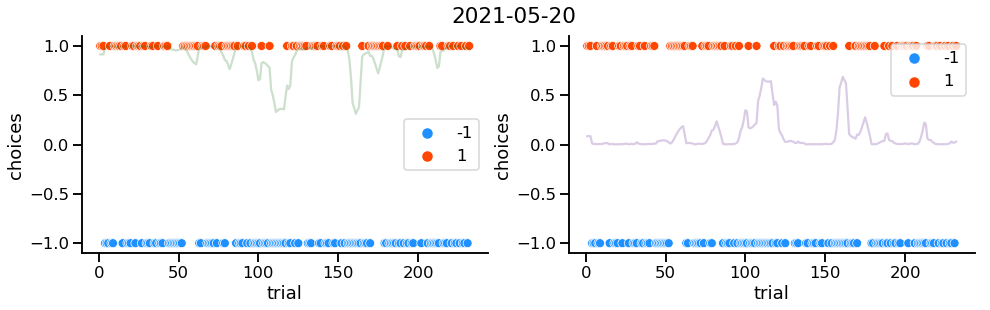

2021-05-21


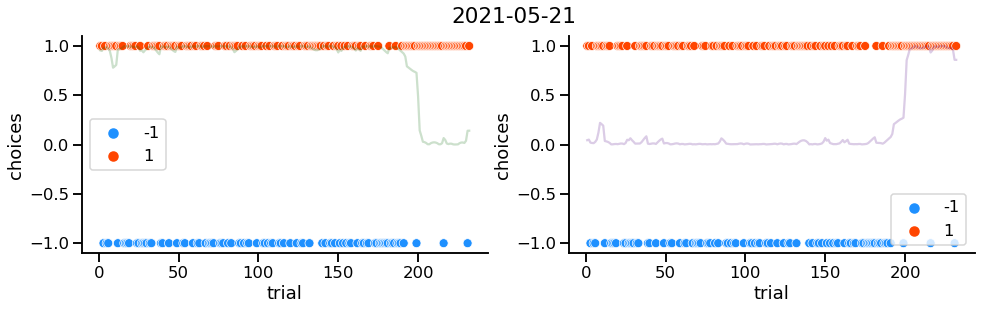

2021-05-22


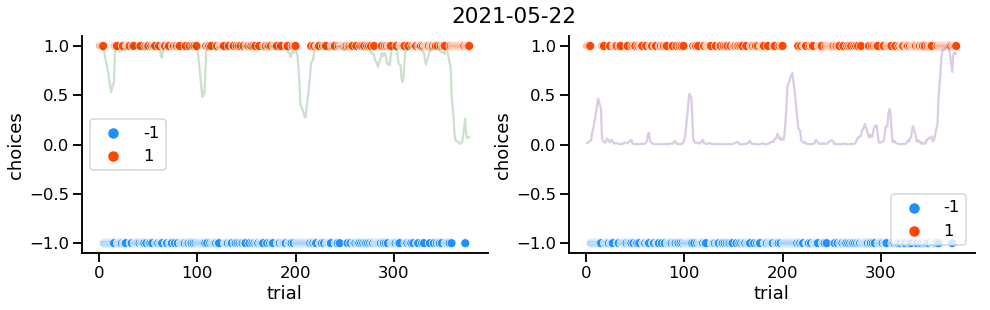

2021-05-25


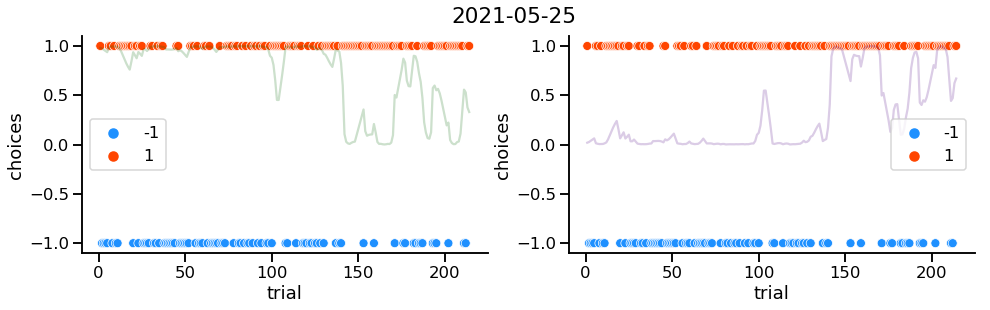

2021-05-26


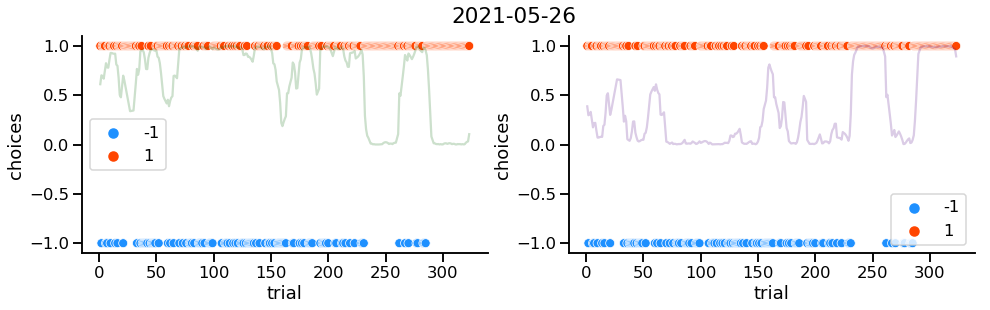

2021-05-28


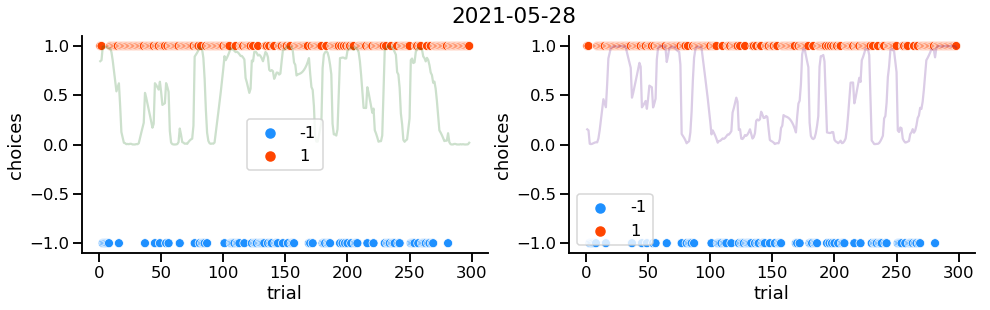

2021-05-29


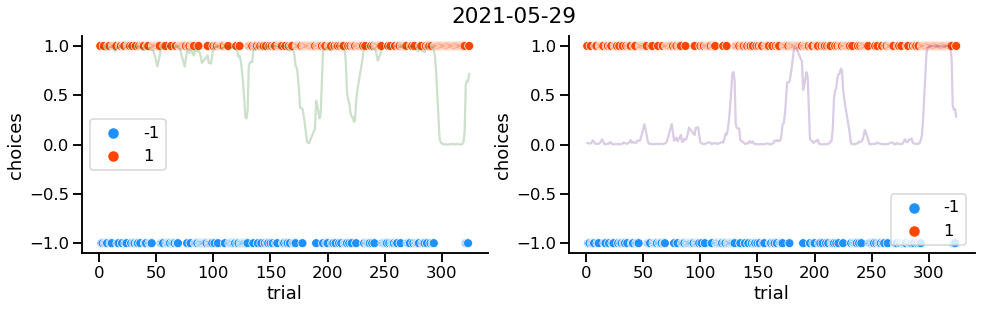

2021-05-30


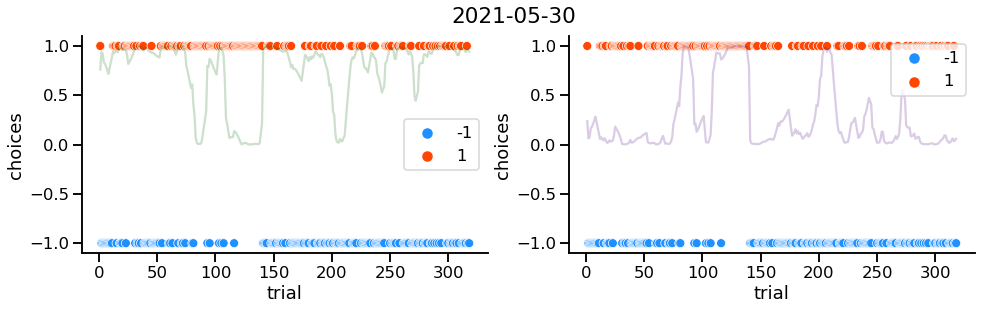

2021-06-01


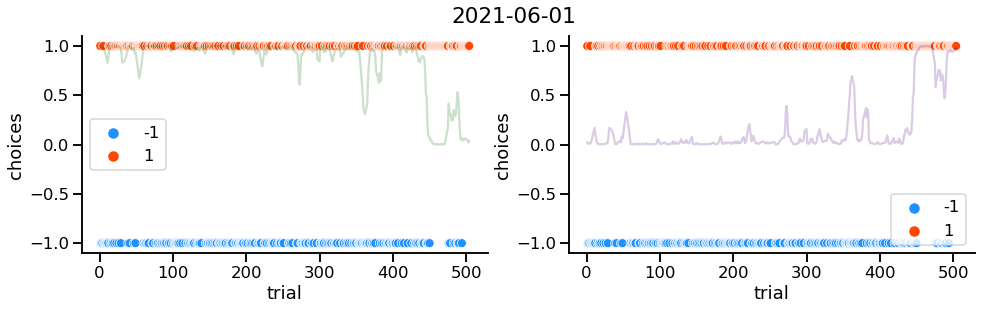

2021-06-02


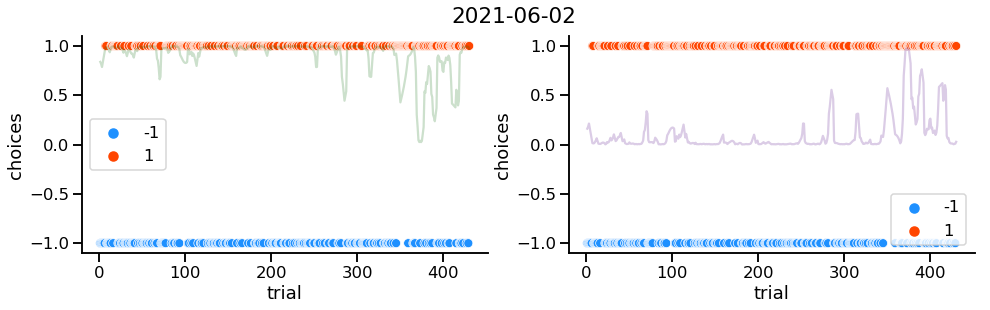

2021-06-03


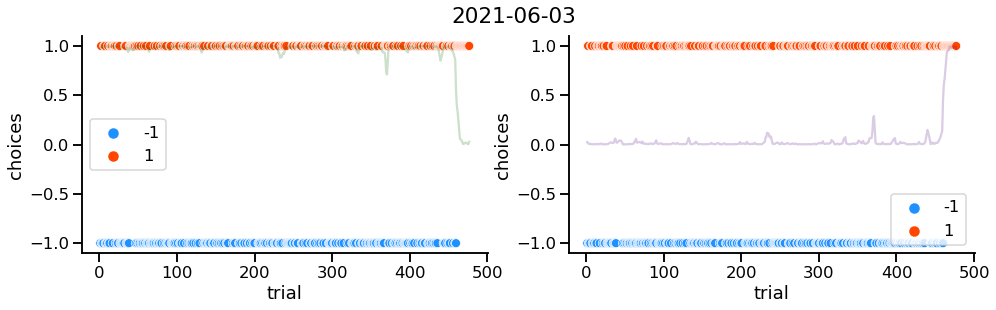

2021-06-04


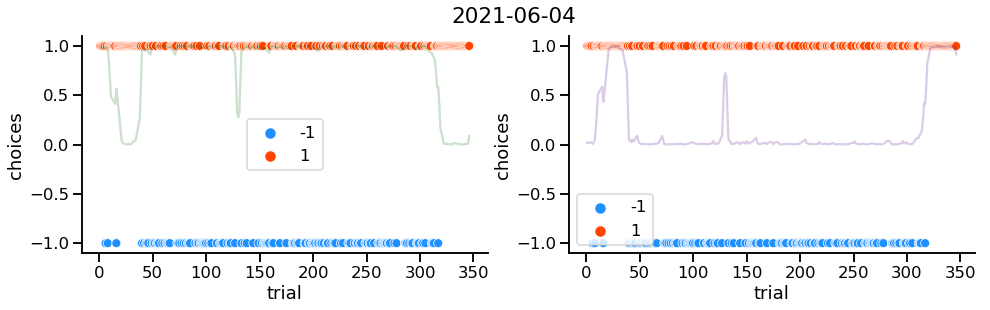

2021-06-05


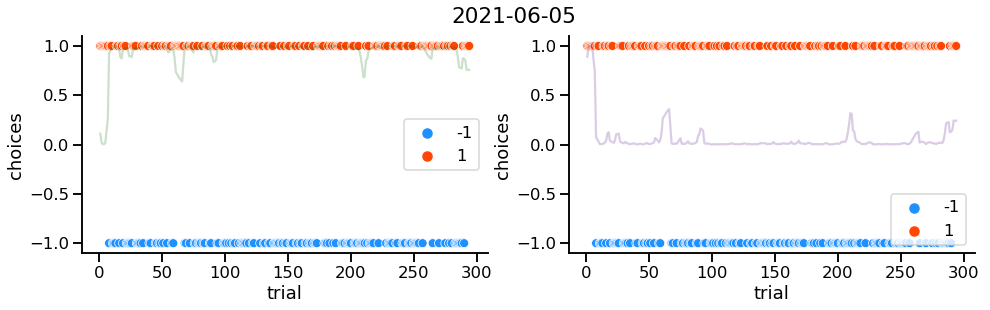

2021-06-06


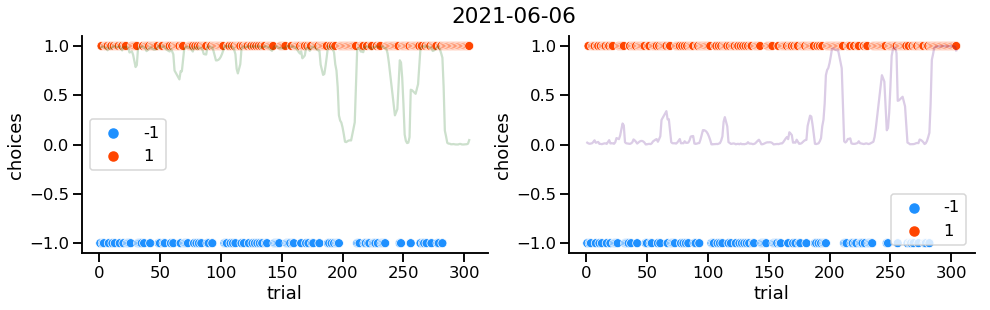

2021-06-07


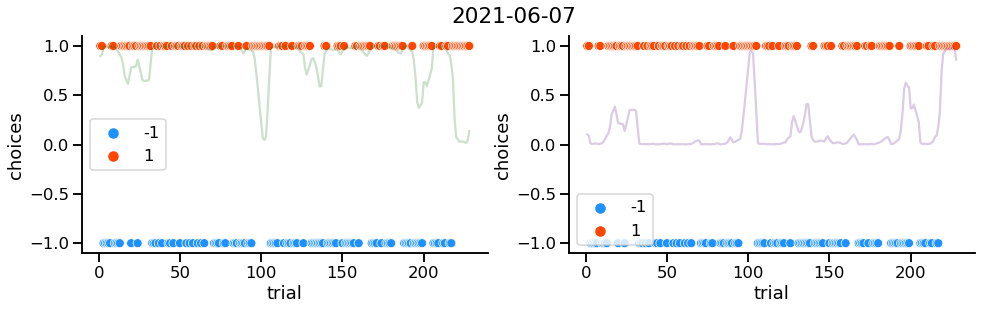

2021-06-08


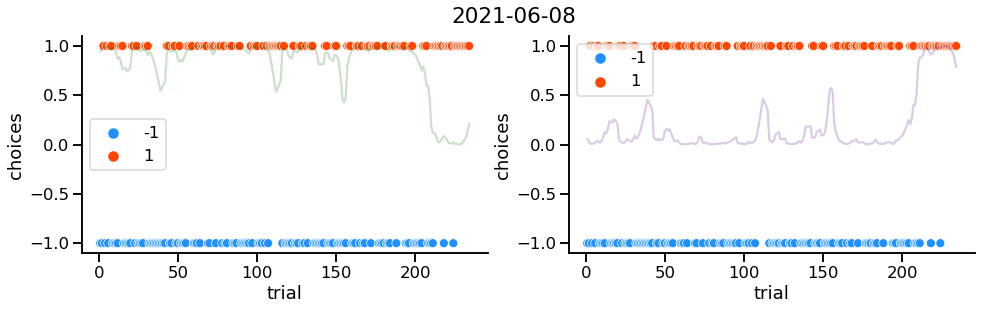

2021-06-09


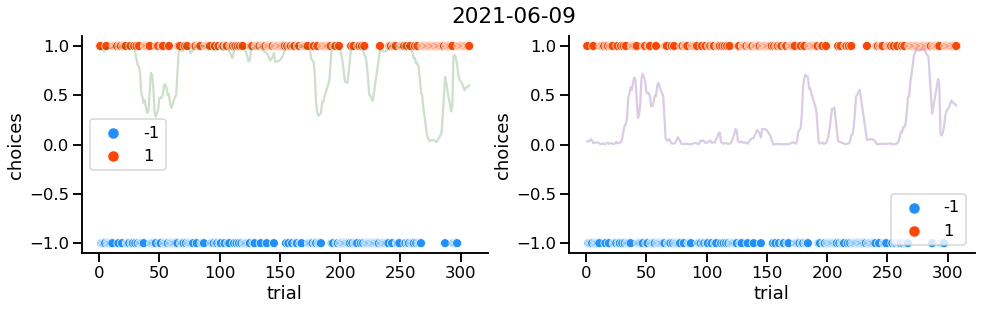

2021-06-10


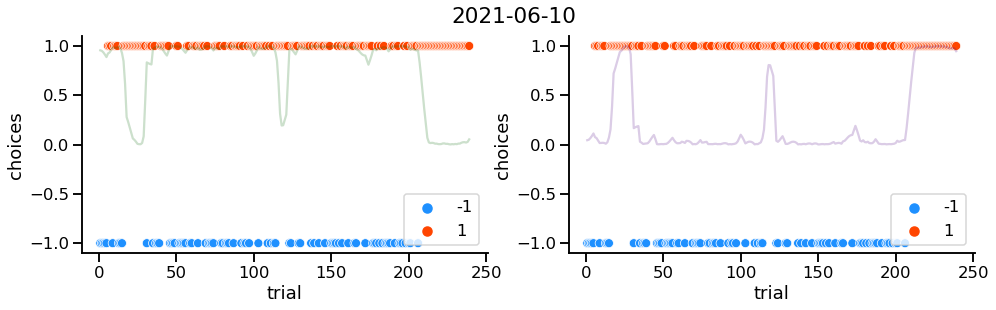

2021-06-11


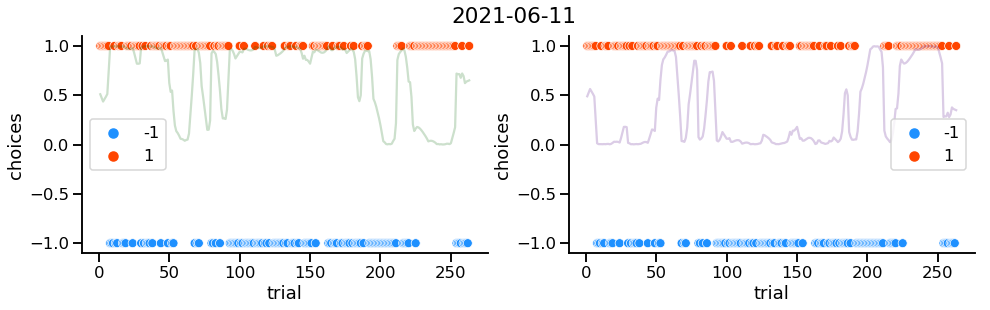

2021-06-12


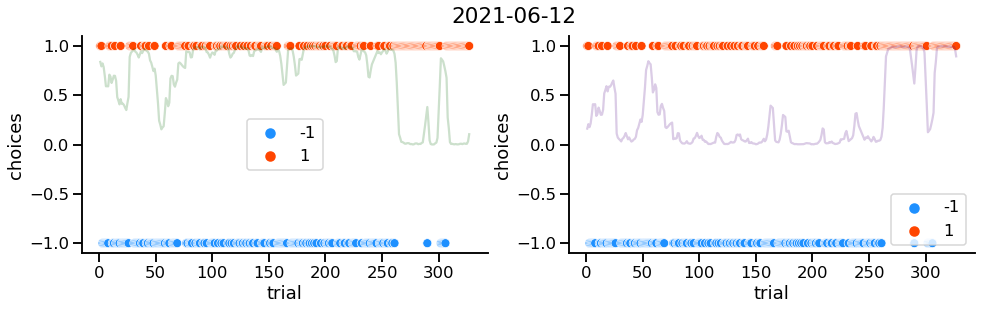

2021-06-14


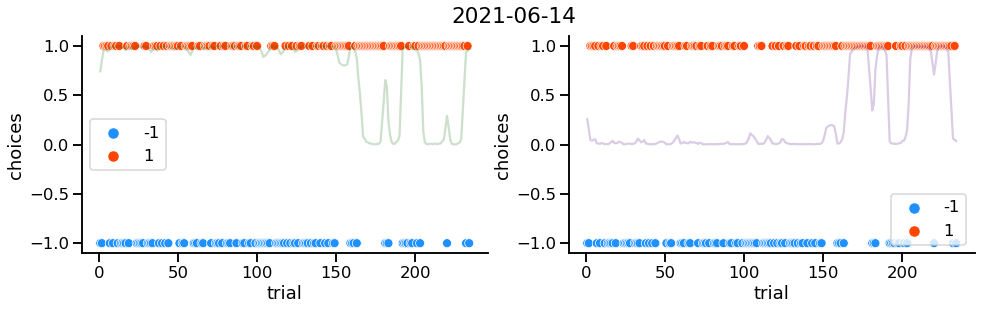

2021-06-15


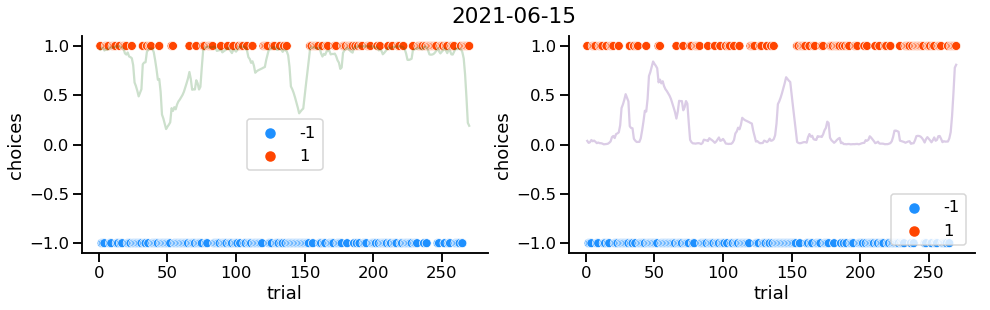

2021-06-17


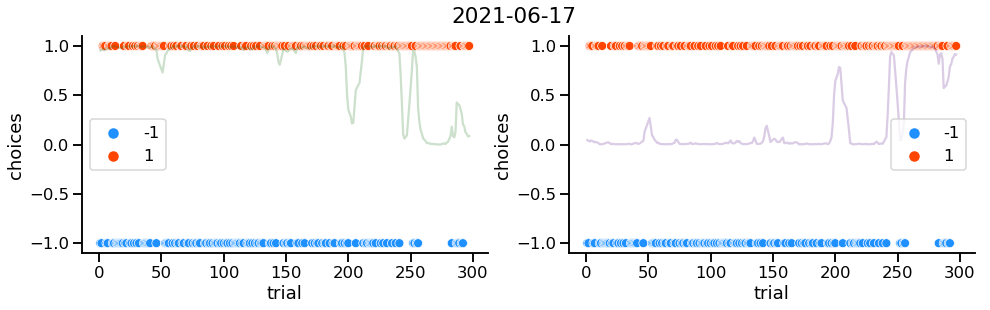

2021-06-18


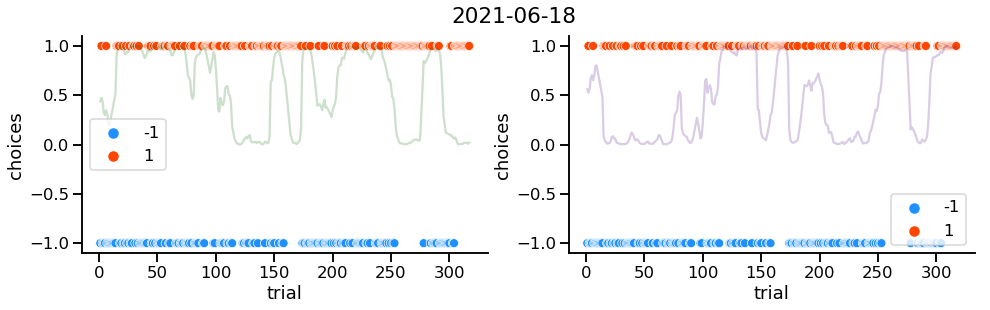

2021-06-19


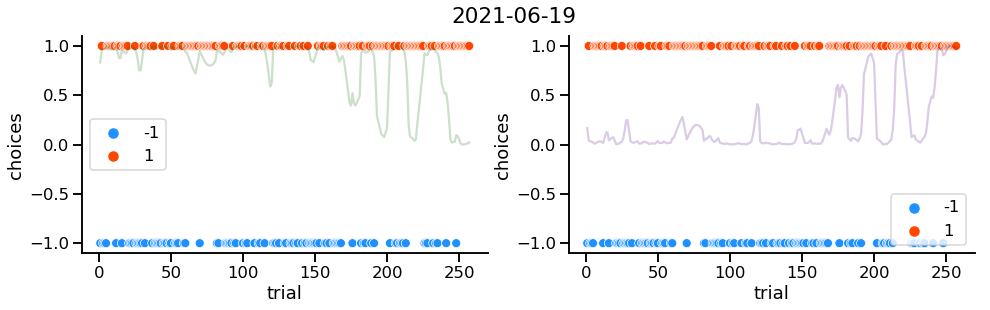

2021-06-21


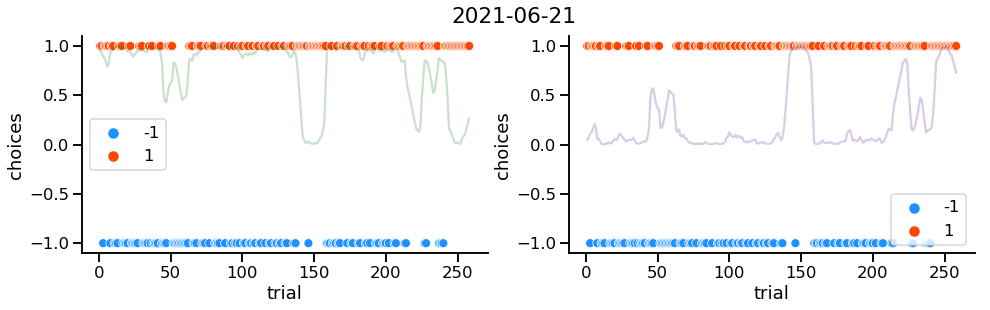

2021-06-23


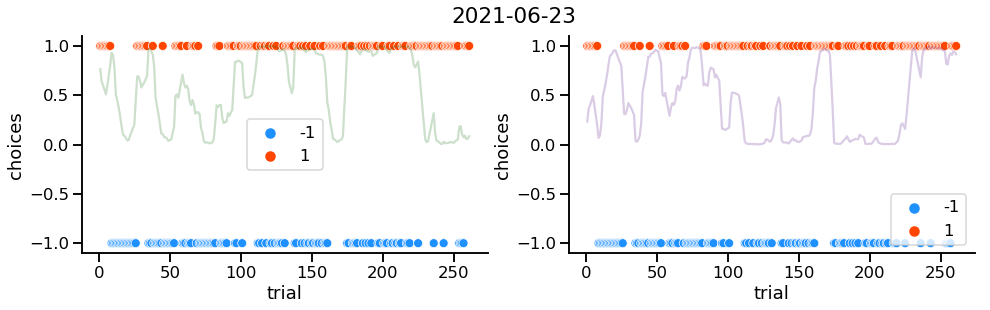

2021-06-24


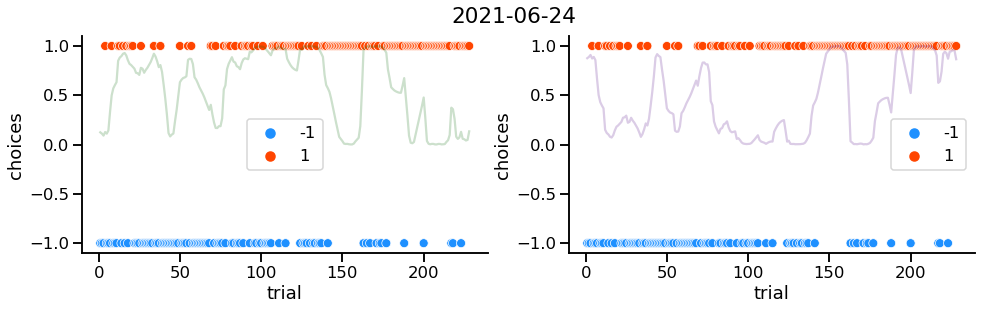

2021-06-25


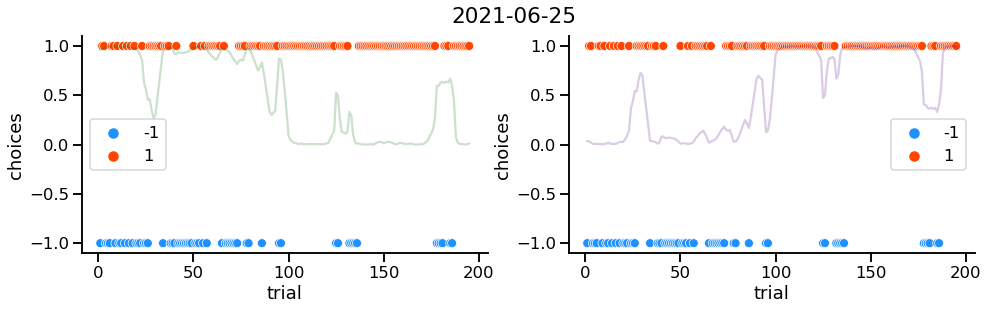

2021-06-26


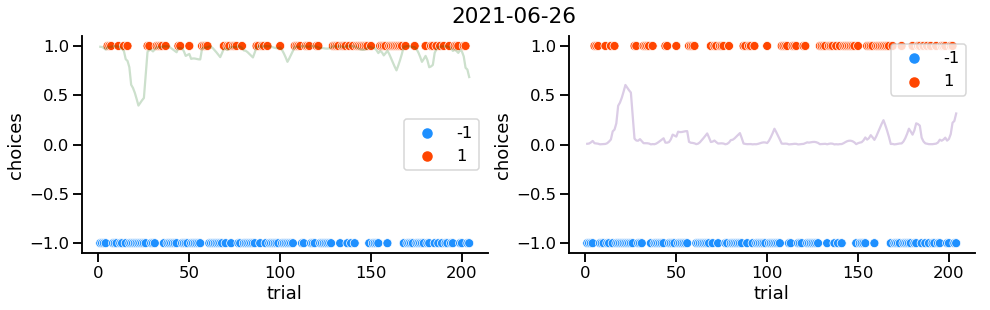

2021-06-28


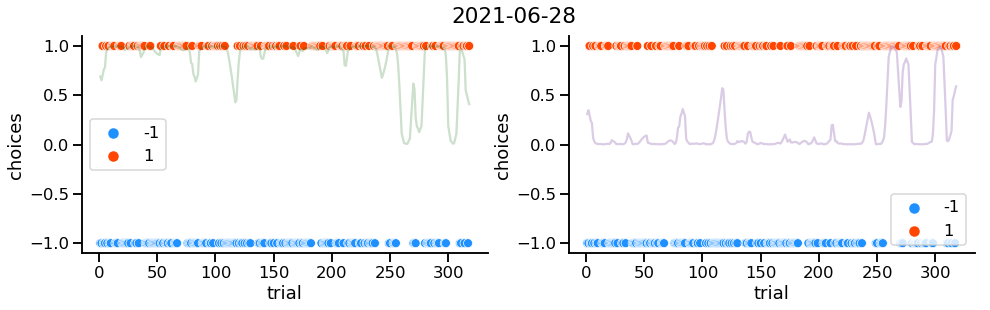

2021-07-03


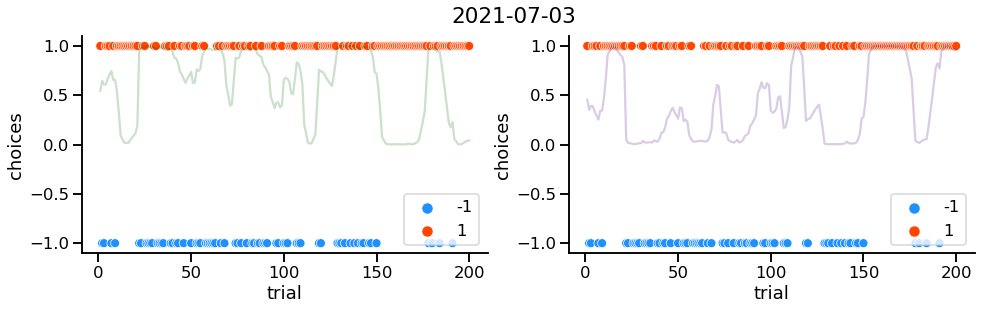

2021-07-04


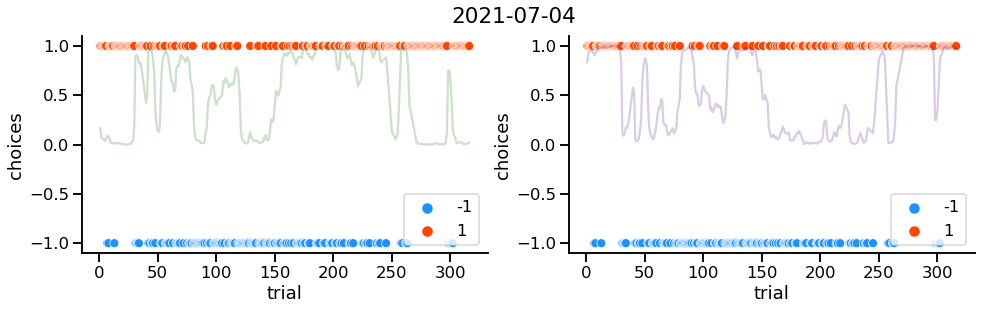

2021-07-07


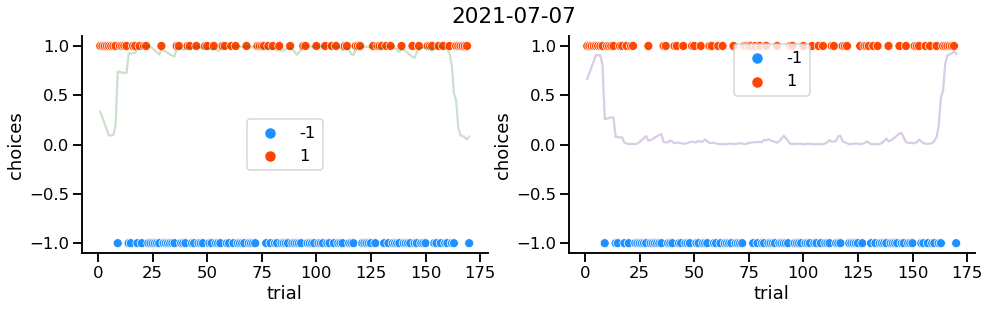

2021-07-08


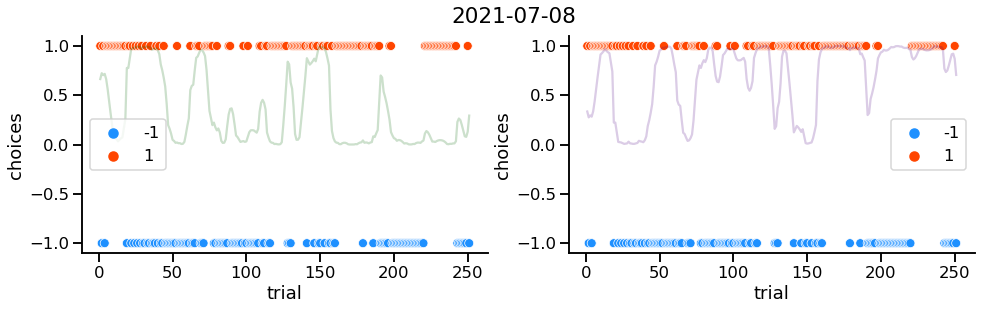

2021-07-09


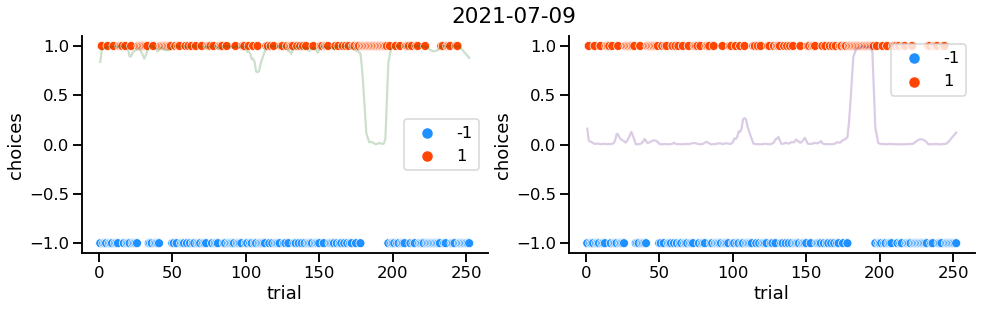

2021-07-12


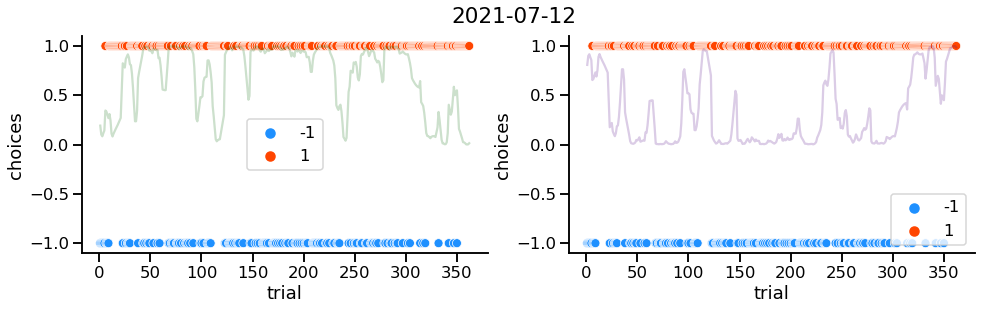

In [13]:
for day in new_df_real.day.unique():
    fig, axes = plt.subplots(1,2, figsize=(16,4))
    plt.suptitle(day)
    print(day)
#     sns.lineplot(x='trial',y='accuracy',data=new_df_real[new_df_real['day'] == day], ax= axes[0], color='darkgreen')
    sns.scatterplot(x='trial',y='choices',data=new_df_real[new_df_real['day'] == day], hue='choices', ax= axes[0], palette=['dodgerblue','orangered'])
    sns.scatterplot(x='trial',y='choices',data=new_df_real[new_df_real['day'] == day], hue='choices', ax= axes[1], palette=['dodgerblue','orangered'])
#     sns.lineplot(x='trial',y='repeat_choice',data=new_df_real[new_df_real['day'] == day], ax= axes[1], color='indigo')

    sns.lineplot(x='trial',y='WM',data=new_df_real[new_df_real['day'] == day], ax= axes[0], color='darkgreen',alpha=0.2)
    sns.lineplot(x='trial',y='RL',data=new_df_real[new_df_real['day'] == day], ax= axes[1], color='indigo',alpha=0.2)
    sns.despine()
    plt.show()

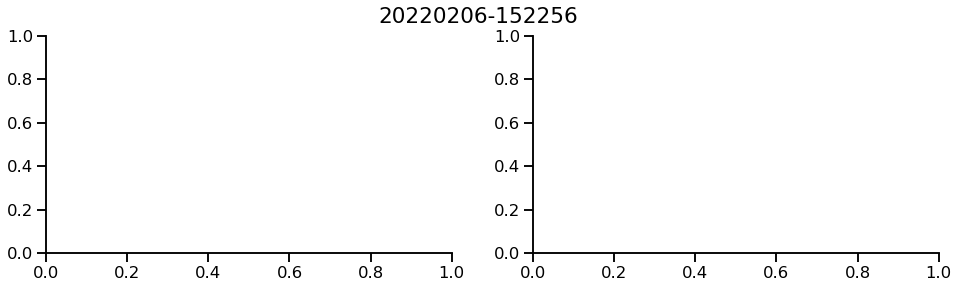

In [14]:
day =  '20220206-152256'
temp_df = new_df_real[(new_df_real['day'] ==day)&(new_df_real['trial'] >= 50)&(new_df_real['trial'] <= 90)]

fig, axes = plt.subplots(1,2, figsize=(16,4))
plt.suptitle(day)
#     sns.lineplot(x='trial',y='accuracy',data=new_df_real[new_df_real['day'] == day], ax= axes[0], color='darkgreen')
sns.scatterplot(x='trial',y=np.repeat(1,len(temp_df)),data=temp_df, hue='choices', ax= axes[0], palette=['dodgerblue','orangered'])
sns.scatterplot(x='trial',y=np.repeat(1.05,len(temp_df)),data=temp_df, hue='hit', ax= axes[0], palette=['crimson','green'])
sns.scatterplot(x='trial',y=np.repeat(1,len(temp_df)),data=temp_df, hue='choices', ax= axes[1], palette=['dodgerblue','orangered'],legend=False)
sns.scatterplot(x='trial',y=np.repeat(1.05,len(temp_df)),data=temp_df, hue='hit', ax= axes[1], palette=['crimson','green'])

# sns.lineplot(x='trial',y='repeat_choice',data=new_df_real[new_df_real['day'] == day], ax= axes[1], color='indigo')

sns.lineplot(x='trial',y='WM',data=temp_df, ax= axes[0], color='darkgreen',alpha=0.2)
sns.lineplot(x='trial',y='RL',data=temp_df, ax= axes[1], color='indigo',alpha=0.2)

sns.despine()
plt.show()

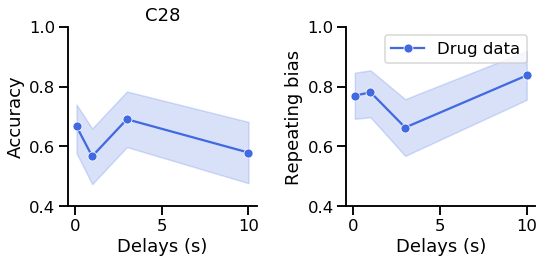

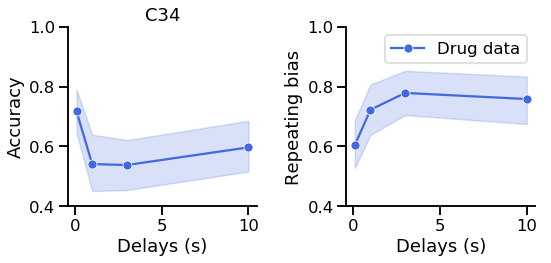

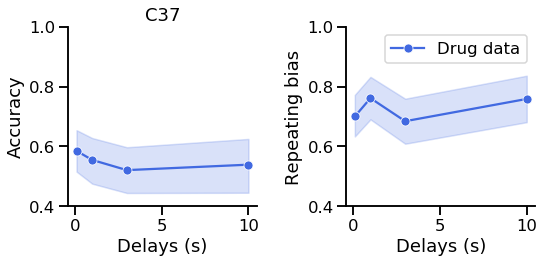

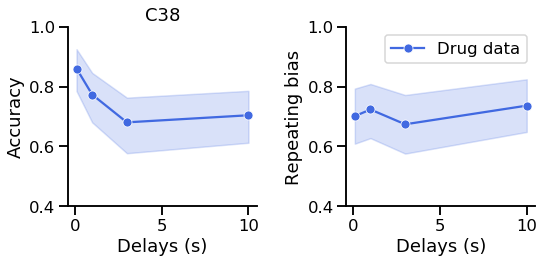

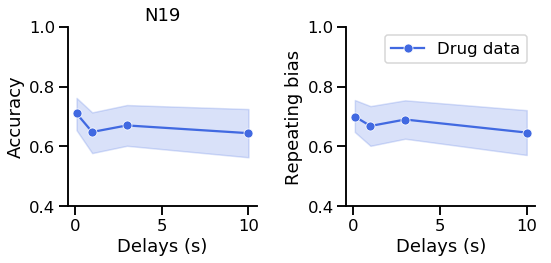

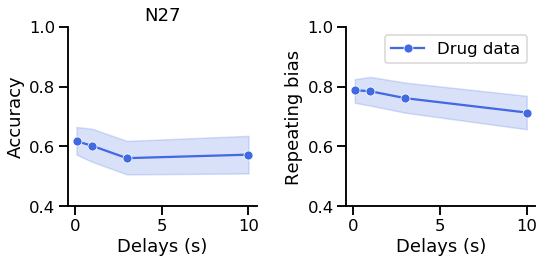

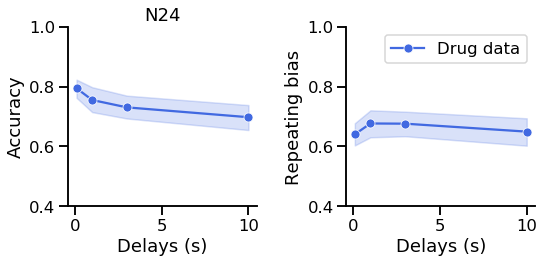

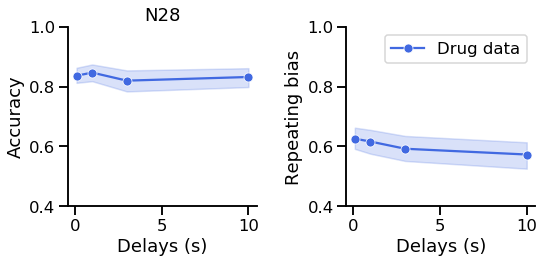

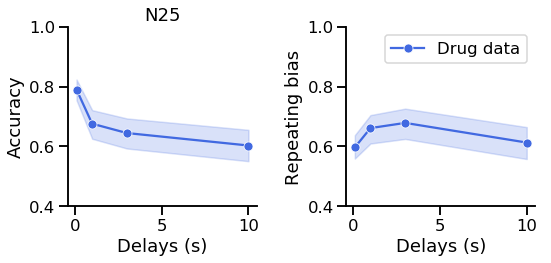

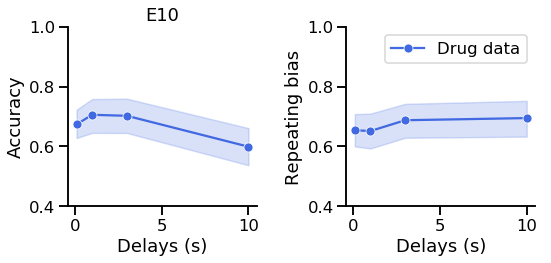

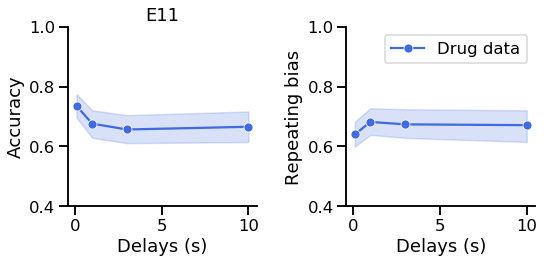

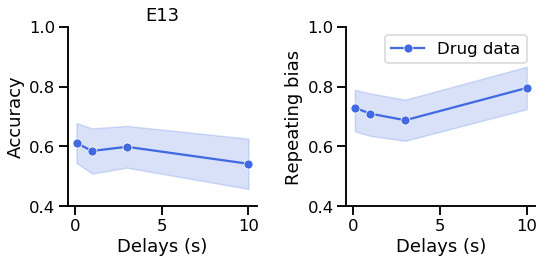

In [15]:
for subject in all_data.subject.unique():
    fig = plt.figure(figsize=(8,4))

    new_df_real = all_data.loc[(all_data.subject==subject)&(all_data.drug=='0')]
    new_df = all_data.loc[(all_data.subject==subject)&(all_data.drug=='NR2B')]

    plt.subplot(121)
    sns.lineplot(x='delays',y='hit',data=new_df_real, marker='o',color='black', )
    sns.lineplot(x='delays',y='hit',data=new_df, marker='o',color='royalblue')

    plt.ylim(0.4,1)
    plt.xlabel("Delays (s)")
    plt.ylabel("Accuracy")
    plt.title(subject)
    sns.despine()

    plt.subplot(122)

    sns.lineplot(x='delays',y='repeat',data=new_df_real, marker='o',color='black', label = 'Saline data')
    sns.lineplot(x='delays',y='repeat',data=new_df, marker='o',color='royalblue',  label = 'Drug data')

    plt.ylim(0.4,1)
    plt.xlabel("Delays (s)")
    plt.ylabel("Repeating bias")
    sns.despine()
    plt.legend()

    # plt.subplot(133)
    # sns.lineplot(x='delays',y='hit',data=new_df_real, marker='o',color='black', linestyle = '')
    # sns.lineplot(x='delays',y='repeat',data=new_df_real,  marker='o', linestyle = '',color='black')

    # sns.lineplot(x='delays',y='hit',data=new_df, color='black', linestyle = ':', err_style=None)
    # sns.lineplot(x='delays',y='repeat',data=new_df, linestyle = ':',color='black', err_style=None)
    # plt.xlabel("Delays (s)")
    # plt.ylabel("Accuracy + RB", )
    # sns.despine()
    # plt.ylim(0.4,1)
    plt.tight_layout()
    plt.show()
    # plt.savefig(animal+'_repeating bias and accuracy comparision.svg')

In [ ]:
fig = plt.figure(figsize=(14,4))

subject='C28'
new_df_real = all_data.loc[(all_data.subject==subject)&(all_data.drug=='Saline')]
new_df = all_data.loc[(all_data.subject==subject)&(all_data.drug=='NR2B')]

plt.subplot(131)
sns.lineplot(x='delays',y='hit',data=new_df_real, marker='o',color='black', linestyle = '', label='All')
sns.lineplot(x='delays',y='hit',data=new_df_real.loc[new_df_real['RL']>0.25],  marker='o', linestyle = '',color='indigo', label='HB module')
sns.lineplot(x='delays',y='hit',data=new_df_real.loc[new_df_real['WM']>0.65], marker='o',linestyle = '',color='darkgreen', label='WM module')
plt.legend()

sns.lineplot(x='delays',y='hit',data=new_df,linestyle = ':',color='black', err_style=None)
sns.lineplot(x='delays',y='hit',data=new_df.loc[new_df['RL']>=0.35],linestyle = ':',color='indigo', err_style=None)
sns.lineplot(x='delays',y='hit',data=new_df.loc[new_df['RL']>=0.65],linestyle = ':',color='darkgreen', err_style=None)

plt.ylim(0.4,1)
plt.xlabel("Delays (s)")
plt.ylabel("Accuracy")
plt.suptitle(animal)
sns.despine()

plt.subplot(132)

sns.lineplot(x='delays',y='repeat',data=new_df_real, marker='o',color='black', linestyle = '', label = 'Real data')
sns.lineplot(x='delays',y='repeat',data=new_df_real.loc[new_df_real['RL']>0.25],  marker='o', linestyle = '',color='indigo')
sns.lineplot(x='delays',y='repeat',data=new_df_real.loc[new_df_real['WM']>0.65], marker='o',linestyle = '',color='darkgreen')

sns.lineplot(x='delays',y='repeat',data=new_df,linestyle = ':',color='black', err_style=None, label = 'Synthetic data')
sns.lineplot(x='delays',y='repeat',data=new_df.loc[new_df['RL']>0.25],linestyle = ':',color='indigo', err_style=None)
sns.lineplot(x='delays',y='repeat',data=new_df.loc[new_df['WM']>0.65],linestyle = ':',color='darkgreen', err_style=None)

plt.ylim(0.4,1)
plt.xlabel("Delays (s)")
plt.ylabel("Repeating bias")
plt.suptitle(animal)
sns.despine()
plt.legend()

# plt.subplot(133)
# sns.lineplot(x='delays',y='hit',data=new_df_real, marker='o',color='black', linestyle = '')
# sns.lineplot(x='delays',y='repeat',data=new_df_real,  marker='o', linestyle = '',color='black')

# sns.lineplot(x='delays',y='hit',data=new_df, color='black', linestyle = ':', err_style=None)
# sns.lineplot(x='delays',y='repeat',data=new_df, linestyle = ':',color='black', err_style=None)
# plt.xlabel("Delays (s)")
# plt.ylabel("Accuracy + RB", )
# sns.despine()
# plt.ylim(0.4,1)
plt.tight_layout()

plt.savefig(animal+'_repeating bias and accuracy comparision.svg')

# **Final Fig. 3**

No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Rest v.s. Saline: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=7.787e-01
Saline v.s. NR2B: t-test paired samples with Bonferroni correction, P_val=4.539e-04 stat=6.241e+00
Rest v.s. NR2B: t-test paired samples with Bonferroni correction, P_val=2.926e-03 stat=4.799e+00


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Rest v.s. Saline: t-test paired samples with Bonferroni correction, P_val=4.941e-01 stat=1.512e+00
Saline v.s. NR2B: t-test paired samples with Bonferroni correction, P_val=6.919e-04 stat=-5.895e+00
Rest v.s. NR2B: t-test paired samples with Bonferroni correction, P_val=2.172e-02 stat=-3.453e+00


C:\Users\Tiffany\Anaconda3\envs\envr\lib\site-packages\ipykernel_launcher.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Tiffany\Anaconda3\envs\envr\lib\site-packages\ipykernel_launcher.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Total trials for WM:  0.8556701030927835
Total trials for RL:  0.14432989690721648
Total trials for WM:  0.8473282442748091
Total trials for RL:  0.15267175572519084
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

drug v.s. Saline: t-test paired samples with Bonferroni correction, P_val=1.389e-02 stat=-3.739e+00
Saline v.s. 0: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=-1.009e+00
drug v.s. 0: t-test paired samples with Bonferroni correction, P_val=2.579e-02 stat=-3.345e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

drug v.s. Saline: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=5.189e-01
Saline v.s. 0: t-test paired samples with Bonferroni correction, P_val=7.117e-01 stat=-1.266e+00
drug v.s. 0: t-tes

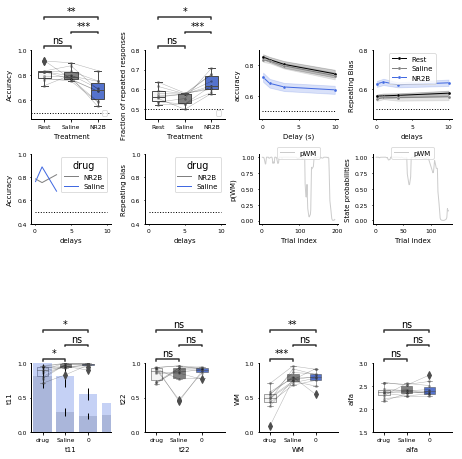

In [10]:
COLORLEFT = 'teal'
COLORRIGHT = '#FF8D3F'

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.anova import AnovaRM
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

from scipy import stats
from scipy import special
import json 
from sklearn.linear_model import LogisticRegression
from scipy.optimize import curve_fit
#Import all needed libraries
from matplotlib.lines import Line2D
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM
from matplotlib.backends.backend_pdf import PdfPages
from statannot import add_stat_annotation
from datahandler import Utils
import warnings

save_path = 'C:/Users/Tiffany/Google Drive/WORKING_MEMORY/PAPER/Panel figures/Fig. 3. Pharma//'
cm = 1/2.54
sns.set_context('paper', rc={'axes.labelsize': 7,
                            'lines.linewidth': 1, 
                            'lines.markersize': 3, 
                            'legend.fontsize': 7,  
                            'xtick.major.size': 1,
                            'xtick.labelsize': 6, 
                            'ytick.major.size': 1, 
                            'ytick.labelsize': 6,
                            'xtick.major.pad': 0,
                            'ytick.major.pad': 0,
                            'xlabel.labelpad': -10})

# Create a figure with 6 subplots using a GridSpec
fig = plt.figure(figsize=(17*cm, 15*cm))
gs = gridspec.GridSpec(nrows=4, ncols=8, figure=fig)

# Create the subplots
a1 = fig.add_subplot(gs[0, 0:2])
a2 = fig.add_subplot(gs[0, 2:4])
a3 = fig.add_subplot(gs[0, 4:6])
a4 = fig.add_subplot(gs[0, 6:8])

b1 = fig.add_subplot(gs[1, 0:2])
b2 = fig.add_subplot(gs[1, 2:4])
b3 = fig.add_subplot(gs[1, 4:6])
b4 = fig.add_subplot(gs[1, 6:8])
c = fig.add_subplot(gs[2, 0:3])

e = fig.add_subplot(gs[3, 0:2])
f = fig.add_subplot(gs[3, 2:4])
g = fig.add_subplot(gs[3, 4:6])
h = fig.add_subplot(gs[3, 6:8])

#-----------------############################## Functions #################################-----------------------

#-----------------########################################################################-----------------------

#-----------------############################## A Panel #################################-----------------------
file_name = 'drug_experiments_df'
df = pd.read_csv(save_path+file_name+'.csv',index_col=0)

panel=a1
df_results = pd.DataFrame()
df_results['accuracy'] = df.loc[(df['drug']=='Saline')|(df['drug']=='NR2B')|(df['drug']=='Rest')].groupby(['subject','drug'])['hit'].mean()
df_results.reset_index(inplace=True)
df_results['drug'] = pd.Categorical(df_results['drug'], categories=['Rest','Saline', 'NR2B'], ordered=True)

palette = sns.color_palette(['black'], len(df_results.subject.unique()))
sns.lineplot(x="drug", y="accuracy",data=df_results, hue='subject', alpha=0.3, ax=panel, linewidth=0.5, markeredgewidth = 0.2,palette=palette,marker='o',legend=False,markersize=3)
sns.boxplot(x='drug',y="accuracy", data=df_results, width=0.5, palette=['whitesmoke','grey','royalblue'],ax=panel, linewidth=1)

panel.set_xlabel('Treatment')
panel.set_ylabel('Accuracy')
panel.set_ylim(0.45,1)
panel.set_xlim(-0.5,2.5)
panel.hlines(y=0.5,xmin=-0.5,xmax=2.5,linestyle=':')
panel.set_xticks([0,1,2],['Rest','Saline','NR2B'])
panel.legend(loc='lower right', ncol=2)

add_stat_annotation(panel, data=df_results, x='drug', y='accuracy',
                    box_pairs=[( "Rest",'Saline'),( "Saline",'NR2B'),( "Rest",'NR2B')],
                    test='t-test_paired', text_format='star', loc='outside', verbose=2)

panel.locator_params(nbins=3)

panel=a2
df_results = pd.DataFrame()
df_results['prob_repeat'] = 0.5* df.loc[df['repeat_choice_side']==1].groupby(['drug','subject'])['hit'].count()/df.loc[df.choices == -1].groupby(['drug','subject'])['hit'].count() + 0.5*df.loc[df['repeat_choice_side']==2].groupby(['drug','subject'])['hit'].count()/df.loc[df.choices == 1].groupby(['drug','subject'])['hit'].count()
df_results.reset_index(inplace=True)
df_results['drug'] = pd.Categorical(df_results['drug'], categories=['Rest','Saline', 'NR2B'], ordered=True)

palette = sns.color_palette(['black'], len(df_results.subject.unique()))
sns.lineplot(x="drug", y="prob_repeat",data=df_results, hue='subject', alpha=0.3, ax=panel, linewidth=0.5, markeredgewidth = 0.2,palette=palette,marker='o',legend=False,markersize=3)
sns.boxplot(x='drug',y="prob_repeat", data=df_results, width=0.5, palette=['whitesmoke','grey','royalblue'],ax=panel, linewidth=1)

panel.set_xlabel('Treatment')
panel.set_ylim(0.45,0.8)
panel.set_ylabel('Repeating bias')

panel.legend(loc='lower right', ncol=2)
panel.hlines(y=0.5,xmin=-0.5,xmax=2.5,linestyle=':')

add_stat_annotation(panel, data=df_results, x='drug', y='prob_repeat',
                    box_pairs=[("Saline", "Rest"),("Saline", "NR2B"),("Rest", "NR2B")],
                    test='t-test_paired', text_format='star', loc='outside', verbose=2)
plt.legend([],[], frameon=False)
panel.set_xticks([0,1,2],['Rest','Saline','NR2B'])
# ---------------------------------------------------------------------------------------------------------------

# -----------------############################## B Panel #################################-----------------------
panel=a3
df_results = pd.DataFrame()
df_results['accuracy'] = df.groupby(['subject','drug','delays'])['hit'].mean()
df_results.reset_index(inplace=True)

sns.lineplot(x='delays',y='accuracy',data=df_results[df_results['drug']=='Rest'],markeredgewidth = 0.2,marker='o',ax=panel, color='black',ci=67)
sns.lineplot(x='delays',y='accuracy',data=df_results[df_results['drug']=='Saline'],markeredgewidth = 0.2,marker='o',ax=panel, color='grey',ci=67)
sns.lineplot(x='delays',y='accuracy',data=df_results[df_results['drug']=='NR2B'],markeredgewidth = 0.2,marker='o',ax=panel, color='royalblue',ci=67)

panel.set_ylim(0.45,0.9)
panel.set_xlabel('Delay (s)')
panel.tick_params(axis='y', colors='black')
panel.yaxis.label.set_color("black")
panel.hlines(xmin=0, xmax=10, y=0.5, linestyle=':')
panel.locator_params(nbins=3)

panel=a4
df_results = pd.DataFrame()
df_results['prob_repeat'] = 0.5* df.loc[df['repeat_choice_side']==1].groupby(['drug','subject','delays'])['hit'].count()/df.loc[df.choices == -1].groupby(['drug','subject','delays'])['hit'].count() + 0.5*df.loc[df['repeat_choice_side']==2].groupby(['drug','subject','delays'])['hit'].count()/df.loc[df.choices == 1].groupby(['drug','subject','delays'])['hit'].count()
df_results.reset_index(inplace=True)

sns.lineplot(x='delays',y='prob_repeat',data=df_results[df_results['drug']=='Rest'],markeredgewidth = 0.2,marker='o',ax=panel, color='black',ci=67, label='Rest')
sns.lineplot(x='delays',y='prob_repeat',data=df_results[df_results['drug']=='Saline'],markeredgewidth = 0.2,marker='o',ax=panel, color='grey',ci=67, label='Saline')
sns.lineplot(x='delays',y='prob_repeat',data=df_results[df_results['drug']=='NR2B'],markeredgewidth = 0.2,marker='o',ax=panel, color='royalblue',ci=67, label='NR2B')

panel.set_ylabel('Repeating Bias')
panel.set_ylim(0.45,0.8)
panel.hlines(xmin=0, xmax=10, y=0.5, linestyle=':')
panel.tick_params(axis='y', colors='black')
panel.locator_params(nbins=3)
# ----------------------------------------------------------------------------------------------------------------

# -----------------############################## C Panel #################################-----------------------
summary_df = pd.DataFrame()
animal = 'C38'
temp_df = df.loc[(df.subject==animal)&(df['session'] == 35)]
temp_df['drug'] ='NR2B'
summary_df = pd.concat([temp_df,summary_df])

panel=b3
sns.lineplot(x='trial',y='WM',data=temp_df, ax= panel, color='black',alpha=0.2, label='pWM')
panel.set_ylabel('p(WM)')
panel.set_xlabel('Trial index')
panel.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),ncol=2)

print('Total trials for WM: ', temp_df[(temp_df["WM"]>0.5)]["stim"].count()/temp_df["stim"].count())
print('Total trials for RL: ', temp_df[(temp_df["RL"]>0.5)]["stim"].count()/temp_df["stim"].count())

temp_df = df.loc[(df.subject==animal)&(df['session'] == 27)]
temp_df['drug'] = 'Saline'
summary_df = pd.concat([temp_df,summary_df])

panel=b4
sns.lineplot(x='trial',y='WM',data=temp_df, ax= panel, color='black',alpha=0.2, label='pWM')
panel.set_ylabel('State probabilities')
panel.set_xlabel('Trial index')
panel.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),ncol=2)

print('Total trials for WM: ', temp_df[(temp_df["WM"]>0.5)]["stim"].count()/temp_df["stim"].count())
print('Total trials for RL: ', temp_df[(temp_df["RL"]>0.5)]["stim"].count()/temp_df["stim"].count())

# ------------ Line plots of delay versus things ----------
panel = b1
sns.lineplot(x='delays',y='hit',data=summary_df, hue='drug',  ci=67, ax= panel, palette=['grey','royalblue'])
panel.set_ylim(0.4,1)
panel.set_ylabel('Accuracy')
panel.hlines(y=0.5, xmin=0,xmax=10,linestyle=':')

panel = b2
sns.lineplot(x='delays',y='repeat',data=summary_df, ci=67, hue = 'drug', ax= panel, palette=['grey','royalblue'])
panel.set_ylim(0.4,1)
panel.set_ylabel('Repeating bias')
panel.hlines(y=0.5, xmin=0,xmax=10,linestyle=':')  

# ----------------------------------------------------------------------------------------------------------------
# -----------------############################## C Panel #################################-----------------------
df_summary = pd.read_csv(save_path+'histogram.csv', index_col=0)
panel=c
panel.bar(np.arange(0,10), df_summary.loc[df_summary['10'] == 'Saline'].iloc[:,:-1].astype(float).mean(axis=0), yerr=df_summary.loc[df_summary['10'] == 'Saline'].iloc[:,:-1].astype(float).sem(axis=0),color='grey', alpha=0.3)
panel.bar(np.arange(0,10), df_summary.loc[df_summary['10'] == 'NR2B'].iloc[:,:-1].astype(float).mean(axis=0), yerr=df_summary.loc[df_summary['10'] == 'NR2B'].iloc[:,:-1].astype(float).sem(axis=0) ,color='royalblue', alpha=0.3)
panel.set_ylabel('Density')
panel.set_xlabel('p(WM)')
panel.set_xticks(np.arange(10),[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

# ----------------------------------------------------------------------------------------------------------------
# -----------------############################## E Panel #################################-----------------------




# -----------------############################## D Panel #################################-----------------------
file_name = 'drug_experiments_fit'
full_fit = pd.read_csv(save_path+file_name+'.csv')
for y, panel in zip(['t11','t22','WM','alfa'], [e,f,g,h]):
#     sns.boxplot(x='drug',y=full_fit[y].astype(float), data=full_fit, palette=['royalblue','grey','whitesmoke'],order=['drug','Saline','0'],ax=ax[i], linewidth=1)
#     sns.lineplot(x="drug", y=full_fit[y].astype(float),data=full_fit, hue='subject', ax=ax[i], linewidth=1.5, palette='binary',marker='o',legend=False,markersize=3)
    
    palette = sns.color_palette(['black'], len(full_fit.subject.unique()))
    sns.lineplot(x="drug", y=full_fit[y].astype(float),data=full_fit, hue='subject',  alpha=0.3, ax=panel, linewidth=0.5, markeredgewidth = 0.2,palette=palette,marker='o',legend=False,markersize=3)
    sns.boxplot(x='drug',y=full_fit[y].astype(float), data=full_fit, width=0.5, palette=['whitesmoke','grey','royalblue'],ax=panel, linewidth=0.5)

    panel.set_xlabel(y)
    panel.set_xlim(-0.5,3)
    panel.set_ylim(0,1)
    panel.set_xticks([0,1,2],['NR2B','Saline','Rest'])
    panel.locator_params(nbins=3)

    plt.legend([],[], frameon=False)
    if y == 'alfa':
        panel.set_ylim(1.5,3)
    add_stat_annotation(panel, data=full_fit, x='drug', y=y,
                        box_pairs=[("Saline", "drug"),("Saline", "0"),("0", "drug")],
                        test='t-test_paired', text_format='star', loc='outside', verbose=2, fontsize=10)
# ----------------------------------------------------------------------------------------------------------------
# Show the figure
sns.despine()
plt.subplots_adjust(left=0.07,
                    bottom=0.07,
                    right=0.97,
                    top=0.97,
                    wspace=1.5,
                    hspace=0.5)
plt.show()

In [ ]:
df_summary = pd.read_csv(save_path+'histogram.csv', index_col=0)
panel=e
panel.bar(np.arange(0,10), df_summary.loc[df_summary['10'] == 'Saline'].iloc[:,:-1].astype(float).mean(axis=0), yerr=df_summary.loc[df_summary[10] == 'Saline'].iloc[:,:-1].astype(float).sem(axis=0),color='grey', alpha=0.3)
panel.bar(np.arange(0,10), df_summary.loc[df_summary['10'] == 'NR2B'].iloc[:,:-1].astype(float).mean(axis=0), yerr=df_summary.loc[df_summary[10] == 'NR2B'].iloc[:,:-1].astype(float).sem(axis=0) ,color='royalblue', alpha=0.3)
panel.set_ylabel('Density')
panel.set_xlabel('p(WM)')
panel.xticks(np.arange(10),[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])